In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [ ]:
import sys
import os
from utils.dataset import SegmentationDataset, get_transforms
from model import UNet
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from google.cloud import storage

In [ ]:

# Función de entrenamiento
def train():
    best_loss = float('inf') 

    for epoch in range(epochs):
        epoch_start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        model.train()
        running_loss = 0.0
        class_correct = torch.zeros(num_classes).to(device)
        class_total = torch.zeros(num_classes).to(device)

        all_preds = []
        all_labels = []

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        for images, masks in loop:
            images, masks = images.to(device), masks.to(device)

        
            optimizer.zero_grad()
            outputs = model(images)

            
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            
            _, predicted = torch.max(outputs, 1)
            for i in range(num_classes):
                if i != 0:  # Ignorar solo la clase 0
                    class_correct[i] += (predicted[masks == i] == i).sum().item()
                    class_total[i] += (masks == i).sum().item()

            
            all_preds.extend(predicted.cpu().numpy().flatten())
            all_labels.extend(masks.cpu().numpy().flatten())

            
            iou_list = calculate_iou(predicted, masks, num_classes)
            dice_list = calculate_dice(predicted, masks, num_classes)

            
            loop.set_postfix(loss=loss.item())

       
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
        print(f'Epoch started at {epoch_start_time} and ended at {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

        for i in range(num_classes):
            if i != 0 and class_total[i] > 0:  # Mostrar accuracy para todas las clases excepto la 0
                acc = 100 * class_correct[i] / class_total[i]
                print(f"Clase {i}: {acc:.2f}% accuracy")
                print(f"Clase {i}: IoU: {iou_list[i-1]:.4f}, Dice: {dice_list[i-1]:.4f}")

       
        scheduler.step(epoch_loss)

        # Guardar el mejor modelo
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            name = f"model_{epoch}_{epoch_loss:.4f}.pth"
            torch.save(model.state_dict(), name)
            print(f"Mejor modelo guardado con Loss: {epoch_loss:.4f}")

        
        # Calculate and display confusion matrix in the last epoch
        if epoch == epochs - 1:
            cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            plt.figure(figsize=(10, 8))
            sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=list(range(num_classes)), yticklabels=list(range(num_classes)))
            plt.xlabel('Predictions')
            plt.ylabel('Labels')
            plt.title(f'Confusion Matrix for Epoch {epoch+1}')
            plt.show()

        # Para Tensorboard
        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch)

def calculate_iou(pred, target, num_classes):
    iou_list = []
    for cls in range(1, num_classes):  # Ignoring class 0
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            iou_list.append(float('nan'))  # If no ground truth, do not include in IoU calculation
        else:
            iou_list.append(intersection / union)
    return iou_list

def calculate_dice(pred, target, num_classes):
    dice_list = []
    for cls in range(1, num_classes):  # Ignoring class 0
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        denominator = pred_inds.sum().item() + target_inds.sum().item()
        if denominator == 0: # To avoid division by zero
            dice = 0
        else:
            dice = (2 * intersection) / denominator
        dice_list.append(dice)
    return dice_list


In [4]:
if torch.backends.mps.is_available():
        device = torch.device('mps')
else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print (f"Device utilizado: {device}")

Device utilizado: cuda


In [13]:
num_classes = 12
batch_size = 12
epochs = 100
lr = 0.001
workers = 5
pin_memory = True
porcentaje_train = 0.8

In [14]:
# Dataset y DataLoader
train_images_dir = "train/img"
train_masks_dir = "train/mask"
train_dataset = SegmentationDataset(train_images_dir, train_masks_dir, transform=get_transforms())


In [15]:
train_size = int(porcentaje_train * len(train_dataset))
val_size = len(train_dataset) - train_size
print(f"Train size images: {train_size}, Validation size images: {val_size}")

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

Train size images: 2436, Validation size images: 609


In [16]:
# Optimización del DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=pin_memory, persistent_workers=True) # persistent_workers
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=pin_memory, persistent_workers=True)

In [ ]:

# Normalización de pesos para la función de pérdida (ignorando solo la clase 0)
class_weights = torch.ones(num_classes).to(device)
class_weights[0] = 0  
criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=0) 

In [ ]:

# Modelo y optimizador
model = UNet(num_classes=num_classes, image_size=300).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Scheduler para reducir el learning rate si la pérdida no mejora
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3) 

In [19]:

# Optimizcaión con DataParallel si hay más de una GPU disponible
print(f"GPUs disponibles: {torch.cuda.device_count()}")
if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
# Tensorboard
writer = SummaryWriter()

GPUs disponibles: 1


Epoch 1/100: 100%|██████████| 203/203 [00:47<00:00,  4.28it/s, loss=1.44]


Epoch 1/100, Loss: 1.4867
Epoch started at 2025-03-17 19:17:31 and ended at 2025-03-17 19:18:18
Clase 1: 75.23% accuracy
Clase 1: IoU: 0.4914, Dice: 0.6590
Clase 2: 2.76% accuracy
Clase 2: IoU: 0.0055, Dice: 0.0110
Clase 3: 80.45% accuracy
Clase 3: IoU: 0.5102, Dice: 0.6757
Clase 4: 11.61% accuracy
Clase 4: IoU: 0.0864, Dice: 0.1590
Clase 5: 0.03% accuracy
Clase 5: IoU: 0.0000, Dice: 0.0000
Clase 6: 0.02% accuracy
Clase 6: IoU: 0.0000, Dice: 0.0000
Clase 7: 0.00% accuracy
Clase 7: IoU: 0.0000, Dice: 0.0000
Clase 8: 0.01% accuracy
Clase 8: IoU: 0.0000, Dice: 0.0000
Clase 9: 0.00% accuracy
Clase 9: IoU: 0.0000, Dice: 0.0000
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 0.03% accuracy
Clase 11: IoU: 0.0000, Dice: 0.0000
Mejor modelo guardado con Loss: 1.4867


Epoch 2/100: 100%|██████████| 203/203 [00:48<00:00,  4.17it/s, loss=1.11]


Epoch 2/100, Loss: 1.2171
Epoch started at 2025-03-17 19:18:22 and ended at 2025-03-17 19:19:15
Clase 1: 76.62% accuracy
Clase 1: IoU: 0.3863, Dice: 0.5573
Clase 2: 12.81% accuracy
Clase 2: IoU: 0.3802, Dice: 0.5509
Clase 3: 79.88% accuracy
Clase 3: IoU: 0.4948, Dice: 0.6621
Clase 4: 34.10% accuracy
Clase 4: IoU: 0.2113, Dice: 0.3489
Clase 5: 0.00% accuracy
Clase 5: IoU: 0.0000, Dice: 0.0000
Clase 6: 2.39% accuracy
Clase 6: IoU: 0.1674, Dice: 0.2868
Clase 7: 0.00% accuracy
Clase 7: IoU: 0.0000, Dice: 0.0000
Clase 8: 0.00% accuracy
Clase 8: IoU: 0.0000, Dice: 0.0000
Clase 9: 0.05% accuracy
Clase 9: IoU: 0.0133, Dice: 0.0263
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 0.00% accuracy
Clase 11: IoU: 0.0000, Dice: 0.0000
Mejor modelo guardado con Loss: 1.2171


Epoch 3/100: 100%|██████████| 203/203 [00:46<00:00,  4.41it/s, loss=1.17]


Epoch 3/100, Loss: 1.1401
Epoch started at 2025-03-17 19:19:16 and ended at 2025-03-17 19:20:07
Clase 1: 72.37% accuracy
Clase 1: IoU: 0.2876, Dice: 0.4467
Clase 2: 38.31% accuracy
Clase 2: IoU: 0.2921, Dice: 0.4522
Clase 3: 80.65% accuracy
Clase 3: IoU: 0.4442, Dice: 0.6151
Clase 4: 37.19% accuracy
Clase 4: IoU: 0.1423, Dice: 0.2492
Clase 5: 0.00% accuracy
Clase 5: IoU: 0.0000, Dice: 0.0000
Clase 6: 60.36% accuracy
Clase 6: IoU: 0.1226, Dice: 0.2184
Clase 7: 0.00% accuracy
Clase 7: IoU: 0.0000, Dice: 0.0000
Clase 8: 0.00% accuracy
Clase 8: IoU: 0.0000, Dice: 0.0000
Clase 9: 1.94% accuracy
Clase 9: IoU: 0.0022, Dice: 0.0044
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 0.00% accuracy
Clase 11: IoU: 0.0000, Dice: 0.0000
Mejor modelo guardado con Loss: 1.1401


Epoch 4/100: 100%|██████████| 203/203 [00:45<00:00,  4.42it/s, loss=1.22]


Epoch 4/100, Loss: 1.0819
Epoch started at 2025-03-17 19:20:10 and ended at 2025-03-17 19:21:02
Clase 1: 75.00% accuracy
Clase 1: IoU: 0.2857, Dice: 0.4445
Clase 2: 43.96% accuracy
Clase 2: IoU: 0.1789, Dice: 0.3034
Clase 3: 81.53% accuracy
Clase 3: IoU: 0.3894, Dice: 0.5605
Clase 4: 39.14% accuracy
Clase 4: IoU: 0.3439, Dice: 0.5118
Clase 5: 0.00% accuracy
Clase 5: IoU: 0.0000, Dice: 0.0000
Clase 6: 67.36% accuracy
Clase 6: IoU: 0.3218, Dice: 0.4869
Clase 7: 0.00% accuracy
Clase 7: IoU: 0.0000, Dice: 0.0000
Clase 8: 0.00% accuracy
Clase 8: IoU: 0.0000, Dice: 0.0000
Clase 9: 1.75% accuracy
Clase 9: IoU: 0.0184, Dice: 0.0362
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 0.00% accuracy
Clase 11: IoU: 0.0000, Dice: 0.0000
Mejor modelo guardado con Loss: 1.0819


Epoch 5/100: 100%|██████████| 203/203 [00:45<00:00,  4.41it/s, loss=0.907]


Epoch 5/100, Loss: 1.0352
Epoch started at 2025-03-17 19:21:05 and ended at 2025-03-17 19:21:56
Clase 1: 76.41% accuracy
Clase 1: IoU: 0.5548, Dice: 0.7137
Clase 2: 44.90% accuracy
Clase 2: IoU: 0.3752, Dice: 0.5457
Clase 3: 82.59% accuracy
Clase 3: IoU: 0.6459, Dice: 0.7848
Clase 4: 40.28% accuracy
Clase 4: IoU: 0.1649, Dice: 0.2831
Clase 5: 0.15% accuracy
Clase 5: IoU: 0.0000, Dice: 0.0000
Clase 6: 65.33% accuracy
Clase 6: IoU: 0.3710, Dice: 0.5412
Clase 7: 0.00% accuracy
Clase 7: IoU: 0.0000, Dice: 0.0000
Clase 8: 0.00% accuracy
Clase 8: IoU: 0.0000, Dice: 0.0000
Clase 9: 7.63% accuracy
Clase 9: IoU: 0.0142, Dice: 0.0281
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 0.00% accuracy
Clase 11: IoU: 0.0000, Dice: 0.0000
Mejor modelo guardado con Loss: 1.0352


Epoch 6/100: 100%|██████████| 203/203 [00:48<00:00,  4.16it/s, loss=0.892]


Epoch 6/100, Loss: 1.0170
Epoch started at 2025-03-17 19:22:03 and ended at 2025-03-17 19:22:57
Clase 1: 76.84% accuracy
Clase 1: IoU: 0.4868, Dice: 0.6549
Clase 2: 47.21% accuracy
Clase 2: IoU: 0.2039, Dice: 0.3388
Clase 3: 83.00% accuracy
Clase 3: IoU: 0.5427, Dice: 0.7036
Clase 4: 41.61% accuracy
Clase 4: IoU: 0.3307, Dice: 0.4970
Clase 5: 0.29% accuracy
Clase 5: IoU: 0.0000, Dice: 0.0000
Clase 6: 67.07% accuracy
Clase 6: IoU: 0.3530, Dice: 0.5218
Clase 7: 0.07% accuracy
Clase 7: IoU: 0.0000, Dice: 0.0000
Clase 8: 0.00% accuracy
Clase 8: IoU: 0.0000, Dice: 0.0000
Clase 9: 7.40% accuracy
Clase 9: IoU: 0.0110, Dice: 0.0217
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 0.00% accuracy
Clase 11: IoU: 0.0000, Dice: 0.0000
Mejor modelo guardado con Loss: 1.0170


Epoch 7/100: 100%|██████████| 203/203 [00:45<00:00,  4.41it/s, loss=0.95]


Epoch 7/100, Loss: 0.9682
Epoch started at 2025-03-17 19:22:58 and ended at 2025-03-17 19:23:49
Clase 1: 78.25% accuracy
Clase 1: IoU: 0.6708, Dice: 0.8030
Clase 2: 50.42% accuracy
Clase 2: IoU: 0.2919, Dice: 0.4519
Clase 3: 84.11% accuracy
Clase 3: IoU: 0.6663, Dice: 0.7997
Clase 4: 43.41% accuracy
Clase 4: IoU: 0.4164, Dice: 0.5880
Clase 5: 1.28% accuracy
Clase 5: IoU: 0.0000, Dice: 0.0000
Clase 6: 66.95% accuracy
Clase 6: IoU: 0.0911, Dice: 0.1669
Clase 7: 2.93% accuracy
Clase 7: IoU: 0.0000, Dice: 0.0000
Clase 8: 0.00% accuracy
Clase 8: IoU: 0.0000, Dice: 0.0000
Clase 9: 11.28% accuracy
Clase 9: IoU: 0.0354, Dice: 0.0684
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 0.00% accuracy
Clase 11: IoU: 0.0000, Dice: 0.0000
Mejor modelo guardado con Loss: 0.9682


Epoch 8/100: 100%|██████████| 203/203 [00:48<00:00,  4.19it/s, loss=1.02]


Epoch 8/100, Loss: 0.9526
Epoch started at 2025-03-17 19:23:52 and ended at 2025-03-17 19:24:46
Clase 1: 78.73% accuracy
Clase 1: IoU: 0.5843, Dice: 0.7376
Clase 2: 50.61% accuracy
Clase 2: IoU: 0.3949, Dice: 0.5662
Clase 3: 84.24% accuracy
Clase 3: IoU: 0.6219, Dice: 0.7669
Clase 4: 44.16% accuracy
Clase 4: IoU: 0.1627, Dice: 0.2799
Clase 5: 3.21% accuracy
Clase 5: IoU: 0.0000, Dice: 0.0000
Clase 6: 66.06% accuracy
Clase 6: IoU: 0.4330, Dice: 0.6044
Clase 7: 11.55% accuracy
Clase 7: IoU: 0.0029, Dice: 0.0058
Clase 8: 0.00% accuracy
Clase 8: IoU: 0.0000, Dice: 0.0000
Clase 9: 17.44% accuracy
Clase 9: IoU: 0.1441, Dice: 0.2519
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 0.00% accuracy
Clase 11: IoU: 0.0000, Dice: 0.0000
Mejor modelo guardado con Loss: 0.9526


Epoch 9/100: 100%|██████████| 203/203 [00:45<00:00,  4.42it/s, loss=1.24]


Epoch 9/100, Loss: 0.9212
Epoch started at 2025-03-17 19:24:50 and ended at 2025-03-17 19:25:41
Clase 1: 79.50% accuracy
Clase 1: IoU: 0.4382, Dice: 0.6094
Clase 2: 55.07% accuracy
Clase 2: IoU: 0.4127, Dice: 0.5843
Clase 3: 84.66% accuracy
Clase 3: IoU: 0.5060, Dice: 0.6720
Clase 4: 44.96% accuracy
Clase 4: IoU: 0.0911, Dice: 0.1669
Clase 5: 6.52% accuracy
Clase 5: IoU: 0.0000, Dice: 0.0000
Clase 6: 64.80% accuracy
Clase 6: IoU: 0.1043, Dice: 0.1888
Clase 7: 18.98% accuracy
Clase 7: IoU: 0.1034, Dice: 0.1874
Clase 8: 0.00% accuracy
Clase 8: IoU: 0.0000, Dice: 0.0000
Clase 9: 24.89% accuracy
Clase 9: IoU: 0.1443, Dice: 0.2522
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 0.00% accuracy
Clase 11: IoU: 0.0000, Dice: 0.0000
Mejor modelo guardado con Loss: 0.9212


Epoch 10/100: 100%|██████████| 203/203 [00:45<00:00,  4.43it/s, loss=0.951]


Epoch 10/100, Loss: 0.9311
Epoch started at 2025-03-17 19:25:44 and ended at 2025-03-17 19:26:35
Clase 1: 78.91% accuracy
Clase 1: IoU: 0.4882, Dice: 0.6561
Clase 2: 53.38% accuracy
Clase 2: IoU: 0.4674, Dice: 0.6371
Clase 3: 84.73% accuracy
Clase 3: IoU: 0.5810, Dice: 0.7349
Clase 4: 43.77% accuracy
Clase 4: IoU: 0.2855, Dice: 0.4442
Clase 5: 9.33% accuracy
Clase 5: IoU: 0.0862, Dice: 0.1586
Clase 6: 64.57% accuracy
Clase 6: IoU: 0.4686, Dice: 0.6381
Clase 7: 19.84% accuracy
Clase 7: IoU: 0.0038, Dice: 0.0076
Clase 8: 0.00% accuracy
Clase 8: IoU: 0.0000, Dice: 0.0000
Clase 9: 29.87% accuracy
Clase 9: IoU: 0.1112, Dice: 0.2001
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 0.01% accuracy
Clase 11: IoU: 0.0000, Dice: 0.0000


Epoch 11/100: 100%|██████████| 203/203 [00:45<00:00,  4.43it/s, loss=0.737]


Epoch 11/100, Loss: 0.8848
Epoch started at 2025-03-17 19:26:35 and ended at 2025-03-17 19:27:27
Clase 1: 80.14% accuracy
Clase 1: IoU: 0.7190, Dice: 0.8365
Clase 2: 57.79% accuracy
Clase 2: IoU: 0.3601, Dice: 0.5296
Clase 3: 85.26% accuracy
Clase 3: IoU: 0.7137, Dice: 0.8329
Clase 4: 47.09% accuracy
Clase 4: IoU: 0.3402, Dice: 0.5077
Clase 5: 13.05% accuracy
Clase 5: IoU: 0.1303, Dice: 0.2305
Clase 6: 63.73% accuracy
Clase 6: IoU: 0.4551, Dice: 0.6255
Clase 7: 23.42% accuracy
Clase 7: IoU: 0.0036, Dice: 0.0072
Clase 8: 0.00% accuracy
Clase 8: IoU: 0.0000, Dice: 0.0000
Clase 9: 34.56% accuracy
Clase 9: IoU: 0.1308, Dice: 0.2314
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 1.13% accuracy
Clase 11: IoU: 0.0273, Dice: 0.0531
Mejor modelo guardado con Loss: 0.8848


Epoch 12/100: 100%|██████████| 203/203 [00:45<00:00,  4.43it/s, loss=0.902]


Epoch 12/100, Loss: 0.8593
Epoch started at 2025-03-17 19:27:30 and ended at 2025-03-17 19:28:21
Clase 1: 80.82% accuracy
Clase 1: IoU: 0.5678, Dice: 0.7243
Clase 2: 57.82% accuracy
Clase 2: IoU: 0.1784, Dice: 0.3028
Clase 3: 86.05% accuracy
Clase 3: IoU: 0.6616, Dice: 0.7963
Clase 4: 48.43% accuracy
Clase 4: IoU: 0.2614, Dice: 0.4145
Clase 5: 13.86% accuracy
Clase 5: IoU: 0.2882, Dice: 0.4475
Clase 6: 65.16% accuracy
Clase 6: IoU: 0.3808, Dice: 0.5516
Clase 7: 25.74% accuracy
Clase 7: IoU: 0.0550, Dice: 0.1043
Clase 8: 0.00% accuracy
Clase 8: IoU: 0.0000, Dice: 0.0000
Clase 9: 42.02% accuracy
Clase 9: IoU: 0.2186, Dice: 0.3588
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 4.57% accuracy
Clase 11: IoU: 0.0160, Dice: 0.0316
Mejor modelo guardado con Loss: 0.8593


Epoch 13/100: 100%|██████████| 203/203 [00:45<00:00,  4.43it/s, loss=0.811]


Epoch 13/100, Loss: 0.8505
Epoch started at 2025-03-17 19:28:25 and ended at 2025-03-17 19:29:16
Clase 1: 80.54% accuracy
Clase 1: IoU: 0.6819, Dice: 0.8108
Clase 2: 59.52% accuracy
Clase 2: IoU: 0.1694, Dice: 0.2897
Clase 3: 85.97% accuracy
Clase 3: IoU: 0.6411, Dice: 0.7813
Clase 4: 49.68% accuracy
Clase 4: IoU: 0.5187, Dice: 0.6831
Clase 5: 15.31% accuracy
Clase 5: IoU: 0.1152, Dice: 0.2067
Clase 6: 65.39% accuracy
Clase 6: IoU: 0.4761, Dice: 0.6451
Clase 7: 28.03% accuracy
Clase 7: IoU: 0.1246, Dice: 0.2216
Clase 8: 0.00% accuracy
Clase 8: IoU: 0.0000, Dice: 0.0000
Clase 9: 42.92% accuracy
Clase 9: IoU: 0.2070, Dice: 0.3430
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 8.09% accuracy
Clase 11: IoU: 0.3901, Dice: 0.5613
Mejor modelo guardado con Loss: 0.8505


Epoch 14/100: 100%|██████████| 203/203 [00:45<00:00,  4.44it/s, loss=0.884]


Epoch 14/100, Loss: 0.8300
Epoch started at 2025-03-17 19:29:23 and ended at 2025-03-17 19:30:14
Clase 1: 81.16% accuracy
Clase 1: IoU: 0.6571, Dice: 0.7931
Clase 2: 61.12% accuracy
Clase 2: IoU: 0.2565, Dice: 0.4083
Clase 3: 86.34% accuracy
Clase 3: IoU: 0.7197, Dice: 0.8370
Clase 4: 50.07% accuracy
Clase 4: IoU: 0.2588, Dice: 0.4112
Clase 5: 18.09% accuracy
Clase 5: IoU: 0.0352, Dice: 0.0679
Clase 6: 68.30% accuracy
Clase 6: IoU: 0.3981, Dice: 0.5695
Clase 7: 27.94% accuracy
Clase 7: IoU: 0.0000, Dice: 0.0000
Clase 8: 0.00% accuracy
Clase 8: IoU: 0.0000, Dice: 0.0000
Clase 9: 46.96% accuracy
Clase 9: IoU: 0.4005, Dice: 0.5720
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 14.31% accuracy
Clase 11: IoU: 0.2490, Dice: 0.3988
Mejor modelo guardado con Loss: 0.8300


Epoch 15/100: 100%|██████████| 203/203 [00:45<00:00,  4.44it/s, loss=0.786]


Epoch 15/100, Loss: 0.8186
Epoch started at 2025-03-17 19:30:17 and ended at 2025-03-17 19:31:08
Clase 1: 81.56% accuracy
Clase 1: IoU: 0.7081, Dice: 0.8291
Clase 2: 62.94% accuracy
Clase 2: IoU: 0.2871, Dice: 0.4461
Clase 3: 86.33% accuracy
Clase 3: IoU: 0.6259, Dice: 0.7699
Clase 4: 50.80% accuracy
Clase 4: IoU: 0.2775, Dice: 0.4344
Clase 5: 17.10% accuracy
Clase 5: IoU: 0.0594, Dice: 0.1122
Clase 6: 67.66% accuracy
Clase 6: IoU: 0.5366, Dice: 0.6984
Clase 7: 31.14% accuracy
Clase 7: IoU: 0.1572, Dice: 0.2718
Clase 8: 0.00% accuracy
Clase 8: IoU: 0.0000, Dice: 0.0000
Clase 9: 47.87% accuracy
Clase 9: IoU: 0.2515, Dice: 0.4019
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 20.47% accuracy
Clase 11: IoU: 0.1765, Dice: 0.3000
Mejor modelo guardado con Loss: 0.8186


Epoch 16/100: 100%|██████████| 203/203 [00:45<00:00,  4.45it/s, loss=0.765]


Epoch 16/100, Loss: 0.7950
Epoch started at 2025-03-17 19:31:12 and ended at 2025-03-17 19:32:03
Clase 1: 82.27% accuracy
Clase 1: IoU: 0.6444, Dice: 0.7838
Clase 2: 63.72% accuracy
Clase 2: IoU: 0.2800, Dice: 0.4374
Clase 3: 86.72% accuracy
Clase 3: IoU: 0.7360, Dice: 0.8479
Clase 4: 53.11% accuracy
Clase 4: IoU: 0.3082, Dice: 0.4712
Clase 5: 18.54% accuracy
Clase 5: IoU: 0.0214, Dice: 0.0420
Clase 6: 70.79% accuracy
Clase 6: IoU: 0.6274, Dice: 0.7711
Clase 7: 31.72% accuracy
Clase 7: IoU: 0.3569, Dice: 0.5260
Clase 8: 0.00% accuracy
Clase 8: IoU: 0.0000, Dice: 0.0000
Clase 9: 48.29% accuracy
Clase 9: IoU: 0.3098, Dice: 0.4731
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 24.74% accuracy
Clase 11: IoU: 0.1056, Dice: 0.1910
Mejor modelo guardado con Loss: 0.7950


Epoch 17/100: 100%|██████████| 203/203 [00:45<00:00,  4.45it/s, loss=0.885]


Epoch 17/100, Loss: 0.7641
Epoch started at 2025-03-17 19:32:06 and ended at 2025-03-17 19:32:57
Clase 1: 82.66% accuracy
Clase 1: IoU: 0.3995, Dice: 0.5710
Clase 2: 66.33% accuracy
Clase 2: IoU: 0.4502, Dice: 0.6209
Clase 3: 87.28% accuracy
Clase 3: IoU: 0.4633, Dice: 0.6333
Clase 4: 54.51% accuracy
Clase 4: IoU: 0.2595, Dice: 0.4121
Clase 5: 22.31% accuracy
Clase 5: IoU: 0.0006, Dice: 0.0012
Clase 6: 72.65% accuracy
Clase 6: IoU: 0.5049, Dice: 0.6710
Clase 7: 35.64% accuracy
Clase 7: IoU: 0.0020, Dice: 0.0039
Clase 8: 0.04% accuracy
Clase 8: IoU: 0.0031, Dice: 0.0063
Clase 9: 50.74% accuracy
Clase 9: IoU: 0.3401, Dice: 0.5076
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 32.74% accuracy
Clase 11: IoU: 0.1561, Dice: 0.2701
Mejor modelo guardado con Loss: 0.7641


Epoch 18/100: 100%|██████████| 203/203 [00:45<00:00,  4.44it/s, loss=0.721]


Epoch 18/100, Loss: 0.7717
Epoch started at 2025-03-17 19:33:04 and ended at 2025-03-17 19:33:55
Clase 1: 81.92% accuracy
Clase 1: IoU: 0.7204, Dice: 0.8375
Clase 2: 65.50% accuracy
Clase 2: IoU: 0.6674, Dice: 0.8005
Clase 3: 87.04% accuracy
Clase 3: IoU: 0.6853, Dice: 0.8132
Clase 4: 54.84% accuracy
Clase 4: IoU: 0.3368, Dice: 0.5039
Clase 5: 21.75% accuracy
Clase 5: IoU: 0.0020, Dice: 0.0041
Clase 6: 72.56% accuracy
Clase 6: IoU: 0.4579, Dice: 0.6282
Clase 7: 35.61% accuracy
Clase 7: IoU: 0.0000, Dice: 0.0000
Clase 8: 0.11% accuracy
Clase 8: IoU: 0.0000, Dice: 0.0000
Clase 9: 50.93% accuracy
Clase 9: IoU: 0.3714, Dice: 0.5416
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 32.47% accuracy
Clase 11: IoU: 0.1069, Dice: 0.1932


Epoch 19/100: 100%|██████████| 203/203 [00:45<00:00,  4.45it/s, loss=0.665]


Epoch 19/100, Loss: 0.7435
Epoch started at 2025-03-17 19:33:55 and ended at 2025-03-17 19:34:46
Clase 1: 83.17% accuracy
Clase 1: IoU: 0.7254, Dice: 0.8409
Clase 2: 67.97% accuracy
Clase 2: IoU: 0.3429, Dice: 0.5107
Clase 3: 87.51% accuracy
Clase 3: IoU: 0.7640, Dice: 0.8662
Clase 4: 55.99% accuracy
Clase 4: IoU: 0.5278, Dice: 0.6909
Clase 5: 24.33% accuracy
Clase 5: IoU: 0.0528, Dice: 0.1004
Clase 6: 74.18% accuracy
Clase 6: IoU: 0.2556, Dice: 0.4072
Clase 7: 36.37% accuracy
Clase 7: IoU: 0.0116, Dice: 0.0230
Clase 8: 0.25% accuracy
Clase 8: IoU: 0.0084, Dice: 0.0167
Clase 9: 51.08% accuracy
Clase 9: IoU: 0.4246, Dice: 0.5961
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 34.69% accuracy
Clase 11: IoU: 0.0112, Dice: 0.0222
Mejor modelo guardado con Loss: 0.7435


Epoch 20/100: 100%|██████████| 203/203 [00:45<00:00,  4.47it/s, loss=0.777]


Epoch 20/100, Loss: 0.7327
Epoch started at 2025-03-17 19:34:49 and ended at 2025-03-17 19:35:40
Clase 1: 83.48% accuracy
Clase 1: IoU: 0.4573, Dice: 0.6276
Clase 2: 68.52% accuracy
Clase 2: IoU: 0.4086, Dice: 0.5802
Clase 3: 87.50% accuracy
Clase 3: IoU: 0.7983, Dice: 0.8878
Clase 4: 56.26% accuracy
Clase 4: IoU: 0.3378, Dice: 0.5050
Clase 5: 25.74% accuracy
Clase 5: IoU: 0.0402, Dice: 0.0772
Clase 6: 76.55% accuracy
Clase 6: IoU: 0.6206, Dice: 0.7659
Clase 7: 38.66% accuracy
Clase 7: IoU: 0.0809, Dice: 0.1496
Clase 8: 0.57% accuracy
Clase 8: IoU: 0.0081, Dice: 0.0161
Clase 9: 52.25% accuracy
Clase 9: IoU: 0.2256, Dice: 0.3681
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 38.38% accuracy
Clase 11: IoU: 0.2916, Dice: 0.4516
Mejor modelo guardado con Loss: 0.7327


Epoch 21/100: 100%|██████████| 203/203 [00:45<00:00,  4.46it/s, loss=0.678]


Epoch 21/100, Loss: 0.6972
Epoch started at 2025-03-17 19:35:44 and ended at 2025-03-17 19:36:34
Clase 1: 84.48% accuracy
Clase 1: IoU: 0.7450, Dice: 0.8539
Clase 2: 71.04% accuracy
Clase 2: IoU: 0.5603, Dice: 0.7182
Clase 3: 88.05% accuracy
Clase 3: IoU: 0.6936, Dice: 0.8191
Clase 4: 58.60% accuracy
Clase 4: IoU: 0.4307, Dice: 0.6021
Clase 5: 28.89% accuracy
Clase 5: IoU: 0.1499, Dice: 0.2607
Clase 6: 79.03% accuracy
Clase 6: IoU: 0.5029, Dice: 0.6693
Clase 7: 40.65% accuracy
Clase 7: IoU: 0.1572, Dice: 0.2717
Clase 8: 1.03% accuracy
Clase 8: IoU: 0.0194, Dice: 0.0380
Clase 9: 52.67% accuracy
Clase 9: IoU: 0.4781, Dice: 0.6469
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 39.03% accuracy
Clase 11: IoU: 0.2296, Dice: 0.3735
Mejor modelo guardado con Loss: 0.6972


Epoch 22/100: 100%|██████████| 203/203 [00:45<00:00,  4.47it/s, loss=0.658]


Epoch 22/100, Loss: 0.6898
Epoch started at 2025-03-17 19:36:38 and ended at 2025-03-17 19:37:29
Clase 1: 84.38% accuracy
Clase 1: IoU: 0.5922, Dice: 0.7439
Clase 2: 71.27% accuracy
Clase 2: IoU: 0.3675, Dice: 0.5375
Clase 3: 88.06% accuracy
Clase 3: IoU: 0.7178, Dice: 0.8357
Clase 4: 59.06% accuracy
Clase 4: IoU: 0.5591, Dice: 0.7172
Clase 5: 28.86% accuracy
Clase 5: IoU: 0.1589, Dice: 0.2742
Clase 6: 79.10% accuracy
Clase 6: IoU: 0.2200, Dice: 0.3606
Clase 7: 42.05% accuracy
Clase 7: IoU: 0.0475, Dice: 0.0907
Clase 8: 1.94% accuracy
Clase 8: IoU: 0.0076, Dice: 0.0150
Clase 9: 54.29% accuracy
Clase 9: IoU: 0.2259, Dice: 0.3685
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 40.76% accuracy
Clase 11: IoU: 0.0497, Dice: 0.0946
Mejor modelo guardado con Loss: 0.6898


Epoch 23/100: 100%|██████████| 203/203 [00:47<00:00,  4.27it/s, loss=0.702]


Epoch 23/100, Loss: 0.6800
Epoch started at 2025-03-17 19:37:35 and ended at 2025-03-17 19:38:28
Clase 1: 84.92% accuracy
Clase 1: IoU: 0.7245, Dice: 0.8403
Clase 2: 71.66% accuracy
Clase 2: IoU: 0.2548, Dice: 0.4061
Clase 3: 88.35% accuracy
Clase 3: IoU: 0.7147, Dice: 0.8336
Clase 4: 59.49% accuracy
Clase 4: IoU: 0.3704, Dice: 0.5406
Clase 5: 31.12% accuracy
Clase 5: IoU: 0.0565, Dice: 0.1070
Clase 6: 80.22% accuracy
Clase 6: IoU: 0.3849, Dice: 0.5559
Clase 7: 41.20% accuracy
Clase 7: IoU: 0.3839, Dice: 0.5548
Clase 8: 2.92% accuracy
Clase 8: IoU: 0.0287, Dice: 0.0557
Clase 9: 52.71% accuracy
Clase 9: IoU: 0.2280, Dice: 0.3713
Clase 10: 0.00% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 40.44% accuracy
Clase 11: IoU: 0.0863, Dice: 0.1589
Mejor modelo guardado con Loss: 0.6800


Epoch 24/100: 100%|██████████| 203/203 [00:45<00:00,  4.47it/s, loss=0.788]


Epoch 24/100, Loss: 0.6532
Epoch started at 2025-03-17 19:38:29 and ended at 2025-03-17 19:39:19
Clase 1: 85.73% accuracy
Clase 1: IoU: 0.6116, Dice: 0.7590
Clase 2: 74.04% accuracy
Clase 2: IoU: 0.4909, Dice: 0.6585
Clase 3: 88.65% accuracy
Clase 3: IoU: 0.6764, Dice: 0.8070
Clase 4: 60.73% accuracy
Clase 4: IoU: 0.4717, Dice: 0.6410
Clase 5: 31.95% accuracy
Clase 5: IoU: 0.0498, Dice: 0.0950
Clase 6: 81.35% accuracy
Clase 6: IoU: 0.5034, Dice: 0.6697
Clase 7: 42.87% accuracy
Clase 7: IoU: 0.3170, Dice: 0.4814
Clase 8: 4.08% accuracy
Clase 8: IoU: 0.0187, Dice: 0.0367
Clase 9: 54.74% accuracy
Clase 9: IoU: 0.3004, Dice: 0.4620
Clase 10: 0.74% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 42.02% accuracy
Clase 11: IoU: 0.3444, Dice: 0.5124
Mejor modelo guardado con Loss: 0.6532


Epoch 25/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.644]


Epoch 25/100, Loss: 0.6562
Epoch started at 2025-03-17 19:39:23 and ended at 2025-03-17 19:40:14
Clase 1: 85.62% accuracy
Clase 1: IoU: 0.6334, Dice: 0.7756
Clase 2: 73.51% accuracy
Clase 2: IoU: 0.2045, Dice: 0.3395
Clase 3: 88.46% accuracy
Clase 3: IoU: 0.7799, Dice: 0.8764
Clase 4: 60.42% accuracy
Clase 4: IoU: 0.4930, Dice: 0.6604
Clase 5: 32.44% accuracy
Clase 5: IoU: 0.4353, Dice: 0.6066
Clase 6: 82.16% accuracy
Clase 6: IoU: 0.5368, Dice: 0.6986
Clase 7: 44.45% accuracy
Clase 7: IoU: 0.4090, Dice: 0.5806
Clase 8: 5.09% accuracy
Clase 8: IoU: 0.0589, Dice: 0.1113
Clase 9: 55.14% accuracy
Clase 9: IoU: 0.2555, Dice: 0.4071
Clase 10: 7.09% accuracy
Clase 10: IoU: 0.1715, Dice: 0.2928
Clase 11: 42.69% accuracy
Clase 11: IoU: 0.4052, Dice: 0.5768


Epoch 26/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.617]


Epoch 26/100, Loss: 0.6333
Epoch started at 2025-03-17 19:40:14 and ended at 2025-03-17 19:41:04
Clase 1: 85.90% accuracy
Clase 1: IoU: 0.5024, Dice: 0.6688
Clase 2: 75.20% accuracy
Clase 2: IoU: 0.5416, Dice: 0.7026
Clase 3: 88.78% accuracy
Clase 3: IoU: 0.7479, Dice: 0.8557
Clase 4: 62.17% accuracy
Clase 4: IoU: 0.4225, Dice: 0.5940
Clase 5: 33.93% accuracy
Clase 5: IoU: 0.5296, Dice: 0.6925
Clase 6: 83.05% accuracy
Clase 6: IoU: 0.6491, Dice: 0.7872
Clase 7: 44.86% accuracy
Clase 7: IoU: 0.1699, Dice: 0.2905
Clase 8: 7.12% accuracy
Clase 8: IoU: 0.0380, Dice: 0.0731
Clase 9: 56.00% accuracy
Clase 9: IoU: 0.4347, Dice: 0.6060
Clase 10: 19.03% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 43.62% accuracy
Clase 11: IoU: 0.0806, Dice: 0.1492
Mejor modelo guardado con Loss: 0.6333


Epoch 27/100: 100%|██████████| 203/203 [00:45<00:00,  4.47it/s, loss=0.659]


Epoch 27/100, Loss: 0.6240
Epoch started at 2025-03-17 19:41:08 and ended at 2025-03-17 19:41:58
Clase 1: 86.34% accuracy
Clase 1: IoU: 0.7147, Dice: 0.8336
Clase 2: 75.63% accuracy
Clase 2: IoU: 0.5669, Dice: 0.7236
Clase 3: 88.89% accuracy
Clase 3: IoU: 0.5689, Dice: 0.7252
Clase 4: 62.66% accuracy
Clase 4: IoU: 0.3308, Dice: 0.4972
Clase 5: 35.06% accuracy
Clase 5: IoU: 0.0660, Dice: 0.1239
Clase 6: 82.99% accuracy
Clase 6: IoU: 0.5704, Dice: 0.7265
Clase 7: 45.23% accuracy
Clase 7: IoU: 0.3564, Dice: 0.5255
Clase 8: 9.17% accuracy
Clase 8: IoU: 0.0580, Dice: 0.1097
Clase 9: 56.18% accuracy
Clase 9: IoU: 0.2508, Dice: 0.4010
Clase 10: 31.05% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 43.61% accuracy
Clase 11: IoU: 0.3891, Dice: 0.5602
Mejor modelo guardado con Loss: 0.6240


Epoch 28/100: 100%|██████████| 203/203 [00:45<00:00,  4.47it/s, loss=0.621]


Epoch 28/100, Loss: 0.6124
Epoch started at 2025-03-17 19:42:02 and ended at 2025-03-17 19:42:53
Clase 1: 86.67% accuracy
Clase 1: IoU: 0.6008, Dice: 0.7506
Clase 2: 76.43% accuracy
Clase 2: IoU: 0.5911, Dice: 0.7430
Clase 3: 89.10% accuracy
Clase 3: IoU: 0.7510, Dice: 0.8578
Clase 4: 63.15% accuracy
Clase 4: IoU: 0.4324, Dice: 0.6038
Clase 5: 35.33% accuracy
Clase 5: IoU: 0.1493, Dice: 0.2598
Clase 6: 83.28% accuracy
Clase 6: IoU: 0.3972, Dice: 0.5686
Clase 7: 46.21% accuracy
Clase 7: IoU: 0.1574, Dice: 0.2719
Clase 8: 10.30% accuracy
Clase 8: IoU: 0.0542, Dice: 0.1028
Clase 9: 56.41% accuracy
Clase 9: IoU: 0.5074, Dice: 0.6732
Clase 10: 37.05% accuracy
Clase 10: IoU: 0.1217, Dice: 0.2170
Clase 11: 43.76% accuracy
Clase 11: IoU: 0.1370, Dice: 0.2409
Mejor modelo guardado con Loss: 0.6124


Epoch 29/100: 100%|██████████| 203/203 [00:45<00:00,  4.44it/s, loss=0.543]


Epoch 29/100, Loss: 0.5958
Epoch started at 2025-03-17 19:42:56 and ended at 2025-03-17 19:43:47
Clase 1: 87.26% accuracy
Clase 1: IoU: 0.6943, Dice: 0.8196
Clase 2: 77.93% accuracy
Clase 2: IoU: 0.7485, Dice: 0.8562
Clase 3: 89.17% accuracy
Clase 3: IoU: 0.7976, Dice: 0.8874
Clase 4: 64.00% accuracy
Clase 4: IoU: 0.6032, Dice: 0.7525
Clase 5: 35.99% accuracy
Clase 5: IoU: 0.1506, Dice: 0.2618
Clase 6: 83.94% accuracy
Clase 6: IoU: 0.5713, Dice: 0.7272
Clase 7: 46.26% accuracy
Clase 7: IoU: 0.4868, Dice: 0.6549
Clase 8: 11.62% accuracy
Clase 8: IoU: 0.1326, Dice: 0.2342
Clase 9: 57.43% accuracy
Clase 9: IoU: 0.3866, Dice: 0.5576
Clase 10: 44.93% accuracy
Clase 10: IoU: 0.1876, Dice: 0.3159
Clase 11: 44.64% accuracy
Clase 11: IoU: 0.2398, Dice: 0.3869
Mejor modelo guardado con Loss: 0.5958


Epoch 30/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.639]


Epoch 30/100, Loss: 0.5848
Epoch started at 2025-03-17 19:43:51 and ended at 2025-03-17 19:44:41
Clase 1: 87.40% accuracy
Clase 1: IoU: 0.6735, Dice: 0.8049
Clase 2: 78.27% accuracy
Clase 2: IoU: 0.5961, Dice: 0.7469
Clase 3: 89.33% accuracy
Clase 3: IoU: 0.6374, Dice: 0.7786
Clase 4: 64.74% accuracy
Clase 4: IoU: 0.4442, Dice: 0.6152
Clase 5: 36.75% accuracy
Clase 5: IoU: 0.0447, Dice: 0.0856
Clase 6: 84.60% accuracy
Clase 6: IoU: 0.5337, Dice: 0.6960
Clase 7: 47.41% accuracy
Clase 7: IoU: 0.3939, Dice: 0.5651
Clase 8: 14.84% accuracy
Clase 8: IoU: 0.2926, Dice: 0.4527
Clase 9: 57.95% accuracy
Clase 9: IoU: 0.3728, Dice: 0.5431
Clase 10: 49.10% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 44.55% accuracy
Clase 11: IoU: 0.2403, Dice: 0.3874
Mejor modelo guardado con Loss: 0.5848


Epoch 31/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.553]


Epoch 31/100, Loss: 0.5888
Epoch started at 2025-03-17 19:44:45 and ended at 2025-03-17 19:45:35
Clase 1: 87.29% accuracy
Clase 1: IoU: 0.7198, Dice: 0.8371
Clase 2: 77.78% accuracy
Clase 2: IoU: 0.6188, Dice: 0.7645
Clase 3: 89.17% accuracy
Clase 3: IoU: 0.8128, Dice: 0.8967
Clase 4: 64.57% accuracy
Clase 4: IoU: 0.5414, Dice: 0.7025
Clase 5: 37.18% accuracy
Clase 5: IoU: 0.4211, Dice: 0.5927
Clase 6: 83.99% accuracy
Clase 6: IoU: 0.5361, Dice: 0.6980
Clase 7: 46.70% accuracy
Clase 7: IoU: 0.5690, Dice: 0.7253
Clase 8: 15.38% accuracy
Clase 8: IoU: 0.1108, Dice: 0.1995
Clase 9: 57.31% accuracy
Clase 9: IoU: 0.2006, Dice: 0.3342
Clase 10: 49.32% accuracy
Clase 10: IoU: 0.5198, Dice: 0.6841
Clase 11: 44.37% accuracy
Clase 11: IoU: 0.2451, Dice: 0.3937


Epoch 32/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.66]


Epoch 32/100, Loss: 0.5748
Epoch started at 2025-03-17 19:45:35 and ended at 2025-03-17 19:46:26
Clase 1: 87.48% accuracy
Clase 1: IoU: 0.7262, Dice: 0.8414
Clase 2: 78.77% accuracy
Clase 2: IoU: 0.5527, Dice: 0.7119
Clase 3: 89.28% accuracy
Clase 3: IoU: 0.6960, Dice: 0.8208
Clase 4: 65.46% accuracy
Clase 4: IoU: 0.4788, Dice: 0.6475
Clase 5: 37.93% accuracy
Clase 5: IoU: 0.2053, Dice: 0.3406
Clase 6: 84.38% accuracy
Clase 6: IoU: 0.5906, Dice: 0.7426
Clase 7: 47.39% accuracy
Clase 7: IoU: 0.0864, Dice: 0.1590
Clase 8: 16.97% accuracy
Clase 8: IoU: 0.0873, Dice: 0.1605
Clase 9: 58.59% accuracy
Clase 9: IoU: 0.5010, Dice: 0.6675
Clase 10: 54.37% accuracy
Clase 10: IoU: 0.5951, Dice: 0.7462
Clase 11: 45.07% accuracy
Clase 11: IoU: 0.5086, Dice: 0.6742
Mejor modelo guardado con Loss: 0.5748


Epoch 33/100: 100%|██████████| 203/203 [00:45<00:00,  4.50it/s, loss=0.507]


Epoch 33/100, Loss: 0.5656
Epoch started at 2025-03-17 19:46:29 and ended at 2025-03-17 19:47:20
Clase 1: 87.90% accuracy
Clase 1: IoU: 0.5460, Dice: 0.7064
Clase 2: 78.89% accuracy
Clase 2: IoU: 0.6054, Dice: 0.7542
Clase 3: 89.50% accuracy
Clase 3: IoU: 0.7142, Dice: 0.8333
Clase 4: 65.88% accuracy
Clase 4: IoU: 0.3855, Dice: 0.5565
Clase 5: 38.49% accuracy
Clase 5: IoU: 0.1444, Dice: 0.2523
Clase 6: 85.30% accuracy
Clase 6: IoU: 0.1406, Dice: 0.2465
Clase 7: 47.88% accuracy
Clase 7: IoU: 0.0392, Dice: 0.0755
Clase 8: 19.28% accuracy
Clase 8: IoU: 0.0867, Dice: 0.1595
Clase 9: 59.30% accuracy
Clase 9: IoU: 0.1287, Dice: 0.2281
Clase 10: 57.06% accuracy
Clase 10: IoU: 0.5437, Dice: 0.7044
Clase 11: 45.15% accuracy
Clase 11: IoU: 0.3790, Dice: 0.5496
Mejor modelo guardado con Loss: 0.5656


Epoch 34/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.661]


Epoch 34/100, Loss: 0.5500
Epoch started at 2025-03-17 19:47:23 and ended at 2025-03-17 19:48:14
Clase 1: 88.35% accuracy
Clase 1: IoU: 0.6976, Dice: 0.8219
Clase 2: 80.06% accuracy
Clase 2: IoU: 0.5238, Dice: 0.6875
Clase 3: 89.62% accuracy
Clase 3: IoU: 0.6131, Dice: 0.7602
Clase 4: 66.77% accuracy
Clase 4: IoU: 0.5868, Dice: 0.7396
Clase 5: 39.02% accuracy
Clase 5: IoU: 0.2323, Dice: 0.3770
Clase 6: 85.86% accuracy
Clase 6: IoU: 0.5952, Dice: 0.7462
Clase 7: 47.95% accuracy
Clase 7: IoU: 0.3336, Dice: 0.5003
Clase 8: 22.08% accuracy
Clase 8: IoU: 0.3199, Dice: 0.4848
Clase 9: 60.06% accuracy
Clase 9: IoU: 0.4583, Dice: 0.6286
Clase 10: 59.88% accuracy
Clase 10: IoU: 0.0844, Dice: 0.1556
Clase 11: 45.66% accuracy
Clase 11: IoU: 0.1746, Dice: 0.2973
Mejor modelo guardado con Loss: 0.5500


Epoch 35/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.517]


Epoch 35/100, Loss: 0.5459
Epoch started at 2025-03-17 19:48:17 and ended at 2025-03-17 19:49:08
Clase 1: 88.53% accuracy
Clase 1: IoU: 0.7519, Dice: 0.8584
Clase 2: 80.59% accuracy
Clase 2: IoU: 0.4841, Dice: 0.6524
Clase 3: 89.55% accuracy
Clase 3: IoU: 0.7653, Dice: 0.8671
Clase 4: 67.14% accuracy
Clase 4: IoU: 0.5964, Dice: 0.7472
Clase 5: 39.72% accuracy
Clase 5: IoU: 0.2173, Dice: 0.3571
Clase 6: 85.26% accuracy
Clase 6: IoU: 0.6149, Dice: 0.7616
Clase 7: 48.07% accuracy
Clase 7: IoU: 0.0819, Dice: 0.1514
Clase 8: 24.23% accuracy
Clase 8: IoU: 0.1095, Dice: 0.1975
Clase 9: 59.93% accuracy
Clase 9: IoU: 0.2582, Dice: 0.4105
Clase 10: 60.53% accuracy
Clase 10: IoU: 0.6455, Dice: 0.7845
Clase 11: 45.08% accuracy
Clase 11: IoU: 0.4493, Dice: 0.6200
Mejor modelo guardado con Loss: 0.5459


Epoch 36/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.512]


Epoch 36/100, Loss: 0.5461
Epoch started at 2025-03-17 19:49:12 and ended at 2025-03-17 19:50:02
Clase 1: 88.41% accuracy
Clase 1: IoU: 0.5846, Dice: 0.7379
Clase 2: 80.15% accuracy
Clase 2: IoU: 0.5189, Dice: 0.6832
Clase 3: 89.67% accuracy
Clase 3: IoU: 0.7653, Dice: 0.8670
Clase 4: 67.06% accuracy
Clase 4: IoU: 0.4438, Dice: 0.6147
Clase 5: 39.14% accuracy
Clase 5: IoU: 0.2226, Dice: 0.3642
Clase 6: 85.54% accuracy
Clase 6: IoU: 0.5687, Dice: 0.7250
Clase 7: 48.52% accuracy
Clase 7: IoU: 0.0164, Dice: 0.0322
Clase 8: 24.79% accuracy
Clase 8: IoU: 0.0370, Dice: 0.0713
Clase 9: 60.09% accuracy
Clase 9: IoU: 0.5936, Dice: 0.7450
Clase 10: 60.53% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 45.40% accuracy
Clase 11: IoU: 0.0655, Dice: 0.1230


Epoch 37/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.628]


Epoch 37/100, Loss: 0.5254
Epoch started at 2025-03-17 19:50:02 and ended at 2025-03-17 19:50:53
Clase 1: 89.01% accuracy
Clase 1: IoU: 0.7392, Dice: 0.8500
Clase 2: 81.47% accuracy
Clase 2: IoU: 0.5373, Dice: 0.6990
Clase 3: 89.88% accuracy
Clase 3: IoU: 0.6398, Dice: 0.7803
Clase 4: 68.23% accuracy
Clase 4: IoU: 0.5028, Dice: 0.6692
Clase 5: 40.54% accuracy
Clase 5: IoU: 0.3910, Dice: 0.5622
Clase 6: 86.44% accuracy
Clase 6: IoU: 0.5696, Dice: 0.7258
Clase 7: 49.02% accuracy
Clase 7: IoU: 0.5245, Dice: 0.6881
Clase 8: 27.22% accuracy
Clase 8: IoU: 0.2086, Dice: 0.3452
Clase 9: 61.62% accuracy
Clase 9: IoU: 0.3714, Dice: 0.5416
Clase 10: 64.51% accuracy
Clase 10: IoU: 0.4512, Dice: 0.6218
Clase 11: 45.84% accuracy
Clase 11: IoU: 0.3408, Dice: 0.5083
Mejor modelo guardado con Loss: 0.5254


Epoch 38/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.431]


Epoch 38/100, Loss: 0.5244
Epoch started at 2025-03-17 19:50:56 and ended at 2025-03-17 19:51:47
Clase 1: 88.89% accuracy
Clase 1: IoU: 0.6916, Dice: 0.8177
Clase 2: 81.38% accuracy
Clase 2: IoU: 0.6352, Dice: 0.7769
Clase 3: 89.91% accuracy
Clase 3: IoU: 0.8348, Dice: 0.9100
Clase 4: 68.37% accuracy
Clase 4: IoU: 0.3705, Dice: 0.5406
Clase 5: 40.03% accuracy
Clase 5: IoU: 0.4023, Dice: 0.5738
Clase 6: 86.45% accuracy
Clase 6: IoU: 0.4671, Dice: 0.6367
Clase 7: 48.85% accuracy
Clase 7: IoU: 0.4463, Dice: 0.6171
Clase 8: 28.67% accuracy
Clase 8: IoU: 0.1865, Dice: 0.3143
Clase 9: 61.28% accuracy
Clase 9: IoU: 0.1560, Dice: 0.2699
Clase 10: 64.91% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 45.53% accuracy
Clase 11: IoU: 0.4320, Dice: 0.6033
Mejor modelo guardado con Loss: 0.5244


Epoch 39/100: 100%|██████████| 203/203 [00:45<00:00,  4.50it/s, loss=0.6]


Epoch 39/100, Loss: 0.5235
Epoch started at 2025-03-17 19:51:50 and ended at 2025-03-17 19:52:41
Clase 1: 88.92% accuracy
Clase 1: IoU: 0.5838, Dice: 0.7372
Clase 2: 81.46% accuracy
Clase 2: IoU: 0.6773, Dice: 0.8076
Clase 3: 89.82% accuracy
Clase 3: IoU: 0.6915, Dice: 0.8176
Clase 4: 68.41% accuracy
Clase 4: IoU: 0.4657, Dice: 0.6355
Clase 5: 41.16% accuracy
Clase 5: IoU: 0.2258, Dice: 0.3685
Clase 6: 85.96% accuracy
Clase 6: IoU: 0.6037, Dice: 0.7529
Clase 7: 48.50% accuracy
Clase 7: IoU: 0.3087, Dice: 0.4717
Clase 8: 29.33% accuracy
Clase 8: IoU: 0.0534, Dice: 0.1015
Clase 9: 61.43% accuracy
Clase 9: IoU: 0.2959, Dice: 0.4566
Clase 10: 65.27% accuracy
Clase 10: IoU: 0.0476, Dice: 0.0909
Clase 11: 45.83% accuracy
Clase 11: IoU: 0.3181, Dice: 0.4826
Mejor modelo guardado con Loss: 0.5235


Epoch 40/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.485]


Epoch 40/100, Loss: 0.5104
Epoch started at 2025-03-17 19:52:44 and ended at 2025-03-17 19:53:35
Clase 1: 89.34% accuracy
Clase 1: IoU: 0.7522, Dice: 0.8586
Clase 2: 82.34% accuracy
Clase 2: IoU: 0.3816, Dice: 0.5524
Clase 3: 90.01% accuracy
Clase 3: IoU: 0.7965, Dice: 0.8867
Clase 4: 69.08% accuracy
Clase 4: IoU: 0.3391, Dice: 0.5064
Clase 5: 41.83% accuracy
Clase 5: IoU: 0.1307, Dice: 0.2311
Clase 6: 86.44% accuracy
Clase 6: IoU: 0.5214, Dice: 0.6854
Clase 7: 49.34% accuracy
Clase 7: IoU: 0.5279, Dice: 0.6910
Clase 8: 30.37% accuracy
Clase 8: IoU: 0.2733, Dice: 0.4293
Clase 9: 61.99% accuracy
Clase 9: IoU: 0.5157, Dice: 0.6805
Clase 10: 66.54% accuracy
Clase 10: IoU: 0.6159, Dice: 0.7623
Clase 11: 45.99% accuracy
Clase 11: IoU: 0.4819, Dice: 0.6504
Mejor modelo guardado con Loss: 0.5104


Epoch 41/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.558]


Epoch 41/100, Loss: 0.4984
Epoch started at 2025-03-17 19:53:38 and ended at 2025-03-17 19:54:29
Clase 1: 89.61% accuracy
Clase 1: IoU: 0.7545, Dice: 0.8601
Clase 2: 82.95% accuracy
Clase 2: IoU: 0.7029, Dice: 0.8255
Clase 3: 90.17% accuracy
Clase 3: IoU: 0.6466, Dice: 0.7854
Clase 4: 69.86% accuracy
Clase 4: IoU: 0.4951, Dice: 0.6623
Clase 5: 42.20% accuracy
Clase 5: IoU: 0.3116, Dice: 0.4751
Clase 6: 86.88% accuracy
Clase 6: IoU: 0.7025, Dice: 0.8252
Clase 7: 49.69% accuracy
Clase 7: IoU: 0.4380, Dice: 0.6091
Clase 8: 33.48% accuracy
Clase 8: IoU: 0.2169, Dice: 0.3564
Clase 9: 63.36% accuracy
Clase 9: IoU: 0.3734, Dice: 0.5437
Clase 10: 68.27% accuracy
Clase 10: IoU: 0.5094, Dice: 0.6750
Clase 11: 46.08% accuracy
Clase 11: IoU: 0.3588, Dice: 0.5281
Mejor modelo guardado con Loss: 0.4984


Epoch 42/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.548]


Epoch 42/100, Loss: 0.4965
Epoch started at 2025-03-17 19:54:33 and ended at 2025-03-17 19:55:23
Clase 1: 89.60% accuracy
Clase 1: IoU: 0.7742, Dice: 0.8727
Clase 2: 82.72% accuracy
Clase 2: IoU: 0.3472, Dice: 0.5155
Clase 3: 90.12% accuracy
Clase 3: IoU: 0.7763, Dice: 0.8741
Clase 4: 70.01% accuracy
Clase 4: IoU: 0.4787, Dice: 0.6475
Clase 5: 42.81% accuracy
Clase 5: IoU: 0.2861, Dice: 0.4449
Clase 6: 87.17% accuracy
Clase 6: IoU: 0.6650, Dice: 0.7988
Clase 7: 50.08% accuracy
Clase 7: IoU: 0.0106, Dice: 0.0210
Clase 8: 33.84% accuracy
Clase 8: IoU: 0.2453, Dice: 0.3940
Clase 9: 63.38% accuracy
Clase 9: IoU: 0.4510, Dice: 0.6216
Clase 10: 69.23% accuracy
Clase 10: IoU: 0.6471, Dice: 0.7857
Clase 11: 46.15% accuracy
Clase 11: IoU: 0.1934, Dice: 0.3241
Mejor modelo guardado con Loss: 0.4965


Epoch 43/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.413]


Epoch 43/100, Loss: 0.4892
Epoch started at 2025-03-17 19:55:27 and ended at 2025-03-17 19:56:17
Clase 1: 89.79% accuracy
Clase 1: IoU: 0.7727, Dice: 0.8718
Clase 2: 83.37% accuracy
Clase 2: IoU: 0.8148, Dice: 0.8980
Clase 3: 90.28% accuracy
Clase 3: IoU: 0.8046, Dice: 0.8917
Clase 4: 70.25% accuracy
Clase 4: IoU: 0.5304, Dice: 0.6932
Clase 5: 43.14% accuracy
Clase 5: IoU: 0.2619, Dice: 0.4151
Clase 6: 86.78% accuracy
Clase 6: IoU: 0.5038, Dice: 0.6701
Clase 7: 50.22% accuracy
Clase 7: IoU: 0.1783, Dice: 0.3027
Clase 8: 34.58% accuracy
Clase 8: IoU: 0.2490, Dice: 0.3988
Clase 9: 63.62% accuracy
Clase 9: IoU: 0.1473, Dice: 0.2568
Clase 10: 69.64% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 46.41% accuracy
Clase 11: IoU: 0.0575, Dice: 0.1087
Mejor modelo guardado con Loss: 0.4892


Epoch 44/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.511]


Epoch 44/100, Loss: 0.4797
Epoch started at 2025-03-17 19:56:21 and ended at 2025-03-17 19:57:11
Clase 1: 89.95% accuracy
Clase 1: IoU: 0.7937, Dice: 0.8850
Clase 2: 83.68% accuracy
Clase 2: IoU: 0.5877, Dice: 0.7403
Clase 3: 90.45% accuracy
Clase 3: IoU: 0.7781, Dice: 0.8752
Clase 4: 70.88% accuracy
Clase 4: IoU: 0.5095, Dice: 0.6751
Clase 5: 43.47% accuracy
Clase 5: IoU: 0.0688, Dice: 0.1287
Clase 6: 87.47% accuracy
Clase 6: IoU: 0.5621, Dice: 0.7197
Clase 7: 50.59% accuracy
Clase 7: IoU: 0.4526, Dice: 0.6231
Clase 8: 36.62% accuracy
Clase 8: IoU: 0.1738, Dice: 0.2962
Clase 9: 64.51% accuracy
Clase 9: IoU: 0.4733, Dice: 0.6425
Clase 10: 70.80% accuracy
Clase 10: IoU: 0.6804, Dice: 0.8098
Clase 11: 46.58% accuracy
Clase 11: IoU: 0.3377, Dice: 0.5050
Mejor modelo guardado con Loss: 0.4797


Epoch 45/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.4]


Epoch 45/100, Loss: 0.4780
Epoch started at 2025-03-17 19:57:15 and ended at 2025-03-17 19:58:05
Clase 1: 89.82% accuracy
Clase 1: IoU: 0.3074, Dice: 0.4703
Clase 2: 83.56% accuracy
Clase 2: IoU: 0.0033, Dice: 0.0066
Clase 3: 90.44% accuracy
Clase 3: IoU: 0.8629, Dice: 0.9264
Clase 4: 71.17% accuracy
Clase 4: IoU: 0.5304, Dice: 0.6931
Clase 5: 44.54% accuracy
Clase 5: IoU: 0.2786, Dice: 0.4358
Clase 6: 87.13% accuracy
Clase 6: IoU: 0.5073, Dice: 0.6731
Clase 7: 50.67% accuracy
Clase 7: IoU: 0.0661, Dice: 0.1240
Clase 8: 36.53% accuracy
Clase 8: IoU: 0.1613, Dice: 0.2778
Clase 9: 64.38% accuracy
Clase 9: IoU: 0.4542, Dice: 0.6247
Clase 10: 71.76% accuracy
Clase 10: IoU: 0.7376, Dice: 0.8490
Clase 11: 46.67% accuracy
Clase 11: IoU: 0.1356, Dice: 0.2389
Mejor modelo guardado con Loss: 0.4780


Epoch 46/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.487]


Epoch 46/100, Loss: 0.4691
Epoch started at 2025-03-17 19:58:16 and ended at 2025-03-17 19:59:06
Clase 1: 90.11% accuracy
Clase 1: IoU: 0.7665, Dice: 0.8678
Clase 2: 83.77% accuracy
Clase 2: IoU: 0.7783, Dice: 0.8753
Clase 3: 90.59% accuracy
Clase 3: IoU: 0.7699, Dice: 0.8700
Clase 4: 71.55% accuracy
Clase 4: IoU: 0.5535, Dice: 0.7126
Clase 5: 44.83% accuracy
Clase 5: IoU: 0.0846, Dice: 0.1560
Clase 6: 87.66% accuracy
Clase 6: IoU: 0.6336, Dice: 0.7757
Clase 7: 50.54% accuracy
Clase 7: IoU: 0.1252, Dice: 0.2225
Clase 8: 37.95% accuracy
Clase 8: IoU: 0.1526, Dice: 0.2648
Clase 9: 65.39% accuracy
Clase 9: IoU: 0.5115, Dice: 0.6768
Clase 10: 72.43% accuracy
Clase 10: IoU: 0.6749, Dice: 0.8059
Clase 11: 46.71% accuracy
Clase 11: IoU: 0.0787, Dice: 0.1459
Mejor modelo guardado con Loss: 0.4691


Epoch 47/100: 100%|██████████| 203/203 [00:45<00:00,  4.46it/s, loss=0.594]


Epoch 47/100, Loss: 0.4909
Epoch started at 2025-03-17 19:59:10 and ended at 2025-03-17 20:00:01
Clase 1: 89.43% accuracy
Clase 1: IoU: 0.7317, Dice: 0.8450
Clase 2: 82.95% accuracy
Clase 2: IoU: 0.4788, Dice: 0.6475
Clase 3: 90.15% accuracy
Clase 3: IoU: 0.6882, Dice: 0.8153
Clase 4: 70.58% accuracy
Clase 4: IoU: 0.4304, Dice: 0.6018
Clase 5: 43.64% accuracy
Clase 5: IoU: 0.0919, Dice: 0.1683
Clase 6: 86.02% accuracy
Clase 6: IoU: 0.4057, Dice: 0.5773
Clase 7: 49.32% accuracy
Clase 7: IoU: 0.3317, Dice: 0.4981
Clase 8: 36.85% accuracy
Clase 8: IoU: 0.1466, Dice: 0.2558
Clase 9: 63.74% accuracy
Clase 9: IoU: 0.2948, Dice: 0.4554
Clase 10: 68.95% accuracy
Clase 10: IoU: 0.3197, Dice: 0.4845
Clase 11: 46.06% accuracy
Clase 11: IoU: 0.0544, Dice: 0.1032


Epoch 48/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.541]


Epoch 48/100, Loss: 0.5193
Epoch started at 2025-03-17 20:00:01 and ended at 2025-03-17 20:00:51
Clase 1: 88.82% accuracy
Clase 1: IoU: 0.7233, Dice: 0.8394
Clase 2: 81.38% accuracy
Clase 2: IoU: 0.7642, Dice: 0.8663
Clase 3: 89.98% accuracy
Clase 3: IoU: 0.7649, Dice: 0.8668
Clase 4: 68.40% accuracy
Clase 4: IoU: 0.6072, Dice: 0.7556
Clase 5: 40.60% accuracy
Clase 5: IoU: 0.2207, Dice: 0.3616
Clase 6: 86.02% accuracy
Clase 6: IoU: 0.7857, Dice: 0.8800
Clase 7: 48.11% accuracy
Clase 7: IoU: 0.2954, Dice: 0.4561
Clase 8: 33.02% accuracy
Clase 8: IoU: 0.3203, Dice: 0.4852
Clase 9: 61.80% accuracy
Clase 9: IoU: 0.5296, Dice: 0.6924
Clase 10: 65.89% accuracy
Clase 10: IoU: 0.6472, Dice: 0.7859
Clase 11: 44.26% accuracy
Clase 11: IoU: 0.1462, Dice: 0.2550


Epoch 49/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.389]


Epoch 49/100, Loss: 0.4671
Epoch started at 2025-03-17 20:00:51 and ended at 2025-03-17 20:01:42
Clase 1: 90.17% accuracy
Clase 1: IoU: 0.8014, Dice: 0.8898
Clase 2: 84.11% accuracy
Clase 2: IoU: 0.7983, Dice: 0.8878
Clase 3: 90.55% accuracy
Clase 3: IoU: 0.8075, Dice: 0.8935
Clase 4: 71.69% accuracy
Clase 4: IoU: 0.6890, Dice: 0.8159
Clase 5: 44.62% accuracy
Clase 5: IoU: 0.3262, Dice: 0.4920
Clase 6: 87.16% accuracy
Clase 6: IoU: 0.7702, Dice: 0.8702
Clase 7: 50.49% accuracy
Clase 7: IoU: 0.0000, Dice: 0.0000
Clase 8: 38.14% accuracy
Clase 8: IoU: 0.3893, Dice: 0.5604
Clase 9: 65.55% accuracy
Clase 9: IoU: 0.5436, Dice: 0.7043
Clase 10: 74.01% accuracy
Clase 10: IoU: 0.4961, Dice: 0.6632
Clase 11: 46.88% accuracy
Clase 11: IoU: 0.5615, Dice: 0.7191
Mejor modelo guardado con Loss: 0.4671


Epoch 50/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.426]


Epoch 50/100, Loss: 0.4467
Epoch started at 2025-03-17 20:01:45 and ended at 2025-03-17 20:02:36
Clase 1: 90.71% accuracy
Clase 1: IoU: 0.8288, Dice: 0.9064
Clase 2: 85.32% accuracy
Clase 2: IoU: 0.4188, Dice: 0.5904
Clase 3: 90.80% accuracy
Clase 3: IoU: 0.7678, Dice: 0.8686
Clase 4: 72.77% accuracy
Clase 4: IoU: 0.7226, Dice: 0.8389
Clase 5: 46.54% accuracy
Clase 5: IoU: 0.4078, Dice: 0.5793
Clase 6: 88.14% accuracy
Clase 6: IoU: 0.6301, Dice: 0.7731
Clase 7: 51.17% accuracy
Clase 7: IoU: 0.1602, Dice: 0.2761
Clase 8: 40.89% accuracy
Clase 8: IoU: 0.2284, Dice: 0.3718
Clase 9: 66.74% accuracy
Clase 9: IoU: 0.4124, Dice: 0.5839
Clase 10: 75.93% accuracy
Clase 10: IoU: 0.6992, Dice: 0.8230
Clase 11: 47.91% accuracy
Clase 11: IoU: 0.2120, Dice: 0.3499
Mejor modelo guardado con Loss: 0.4467


Epoch 51/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.363]


Epoch 51/100, Loss: 0.4413
Epoch started at 2025-03-17 20:02:43 and ended at 2025-03-17 20:03:33
Clase 1: 90.79% accuracy
Clase 1: IoU: 0.7827, Dice: 0.8781
Clase 2: 85.35% accuracy
Clase 2: IoU: 0.5108, Dice: 0.6762
Clase 3: 90.88% accuracy
Clase 3: IoU: 0.8767, Dice: 0.9343
Clase 4: 73.08% accuracy
Clase 4: IoU: 0.5620, Dice: 0.7196
Clase 5: 46.81% accuracy
Clase 5: IoU: 0.4155, Dice: 0.5870
Clase 6: 87.96% accuracy
Clase 6: IoU: 0.6870, Dice: 0.8145
Clase 7: 51.73% accuracy
Clase 7: IoU: 0.1247, Dice: 0.2217
Clase 8: 42.25% accuracy
Clase 8: IoU: 0.3004, Dice: 0.4621
Clase 9: 67.69% accuracy
Clase 9: IoU: 0.6977, Dice: 0.8220
Clase 10: 77.29% accuracy
Clase 10: IoU: 0.3484, Dice: 0.5167
Clase 11: 48.03% accuracy
Clase 11: IoU: 0.4790, Dice: 0.6478
Mejor modelo guardado con Loss: 0.4413


Epoch 52/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.437]


Epoch 52/100, Loss: 0.4425
Epoch started at 2025-03-17 20:03:37 and ended at 2025-03-17 20:04:28
Clase 1: 90.75% accuracy
Clase 1: IoU: 0.5780, Dice: 0.7326
Clase 2: 85.23% accuracy
Clase 2: IoU: 0.6537, Dice: 0.7906
Clase 3: 90.85% accuracy
Clase 3: IoU: 0.7561, Dice: 0.8611
Clase 4: 73.02% accuracy
Clase 4: IoU: 0.5278, Dice: 0.6909
Clase 5: 47.25% accuracy
Clase 5: IoU: 0.3426, Dice: 0.5103
Clase 6: 88.04% accuracy
Clase 6: IoU: 0.0000, Dice: 0.0000
Clase 7: 51.90% accuracy
Clase 7: IoU: 0.1660, Dice: 0.2848
Clase 8: 42.68% accuracy
Clase 8: IoU: 0.2391, Dice: 0.3860
Clase 9: 67.64% accuracy
Clase 9: IoU: 0.3468, Dice: 0.5150
Clase 10: 76.42% accuracy
Clase 10: IoU: 0.6417, Dice: 0.7818
Clase 11: 47.77% accuracy
Clase 11: IoU: 0.1209, Dice: 0.2157


Epoch 53/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.367]


Epoch 53/100, Loss: 0.4441
Epoch started at 2025-03-17 20:04:28 and ended at 2025-03-17 20:05:18
Clase 1: 90.57% accuracy
Clase 1: IoU: 0.8235, Dice: 0.9032
Clase 2: 85.10% accuracy
Clase 2: IoU: 0.4758, Dice: 0.6448
Clase 3: 90.82% accuracy
Clase 3: IoU: 0.8725, Dice: 0.9319
Clase 4: 72.97% accuracy
Clase 4: IoU: 0.4573, Dice: 0.6276
Clase 5: 46.95% accuracy
Clase 5: IoU: 0.1586, Dice: 0.2738
Clase 6: 88.04% accuracy
Clase 6: IoU: 0.7477, Dice: 0.8557
Clase 7: 51.18% accuracy
Clase 7: IoU: 0.1504, Dice: 0.2614
Clase 8: 41.91% accuracy
Clase 8: IoU: 0.3527, Dice: 0.5215
Clase 9: 66.98% accuracy
Clase 9: IoU: 0.4796, Dice: 0.6482
Clase 10: 75.74% accuracy
Clase 10: IoU: 0.6520, Dice: 0.7894
Clase 11: 47.59% accuracy
Clase 11: IoU: 0.0880, Dice: 0.1618


Epoch 54/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.448]


Epoch 54/100, Loss: 0.4284
Epoch started at 2025-03-17 20:05:18 and ended at 2025-03-17 20:06:09
Clase 1: 91.09% accuracy
Clase 1: IoU: 0.7966, Dice: 0.8868
Clase 2: 86.01% accuracy
Clase 2: IoU: 0.6247, Dice: 0.7690
Clase 3: 91.07% accuracy
Clase 3: IoU: 0.7944, Dice: 0.8854
Clase 4: 73.71% accuracy
Clase 4: IoU: 0.6309, Dice: 0.7737
Clase 5: 47.67% accuracy
Clase 5: IoU: 0.2308, Dice: 0.3750
Clase 6: 88.14% accuracy
Clase 6: IoU: 0.7538, Dice: 0.8596
Clase 7: 52.42% accuracy
Clase 7: IoU: 0.3925, Dice: 0.5637
Clase 8: 44.68% accuracy
Clase 8: IoU: 0.3429, Dice: 0.5107
Clase 9: 68.51% accuracy
Clase 9: IoU: 0.4600, Dice: 0.6301
Clase 10: 78.33% accuracy
Clase 10: IoU: 0.5362, Dice: 0.6981
Clase 11: 48.43% accuracy
Clase 11: IoU: 0.2037, Dice: 0.3385
Mejor modelo guardado con Loss: 0.4284


Epoch 55/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.484]


Epoch 55/100, Loss: 0.4212
Epoch started at 2025-03-17 20:06:12 and ended at 2025-03-17 20:07:03
Clase 1: 91.19% accuracy
Clase 1: IoU: 0.7846, Dice: 0.8793
Clase 2: 86.32% accuracy
Clase 2: IoU: 0.7635, Dice: 0.8659
Clase 3: 91.10% accuracy
Clase 3: IoU: 0.7926, Dice: 0.8843
Clase 4: 74.34% accuracy
Clase 4: IoU: 0.5653, Dice: 0.7223
Clase 5: 48.23% accuracy
Clase 5: IoU: 0.2035, Dice: 0.3382
Clase 6: 88.25% accuracy
Clase 6: IoU: 0.7204, Dice: 0.8374
Clase 7: 51.96% accuracy
Clase 7: IoU: 0.4177, Dice: 0.5893
Clase 8: 44.95% accuracy
Clase 8: IoU: 0.4308, Dice: 0.6022
Clase 9: 68.86% accuracy
Clase 9: IoU: 0.5732, Dice: 0.7287
Clase 10: 78.87% accuracy
Clase 10: IoU: 0.6696, Dice: 0.8021
Clase 11: 48.86% accuracy
Clase 11: IoU: 0.2428, Dice: 0.3907
Mejor modelo guardado con Loss: 0.4212


Epoch 56/100: 100%|██████████| 203/203 [00:45<00:00,  4.50it/s, loss=0.463]


Epoch 56/100, Loss: 0.4294
Epoch started at 2025-03-17 20:07:06 and ended at 2025-03-17 20:07:57
Clase 1: 90.97% accuracy
Clase 1: IoU: 0.7328, Dice: 0.8458
Clase 2: 85.82% accuracy
Clase 2: IoU: 0.7944, Dice: 0.8854
Clase 3: 90.99% accuracy
Clase 3: IoU: 0.7616, Dice: 0.8647
Clase 4: 73.62% accuracy
Clase 4: IoU: 0.5485, Dice: 0.7084
Clase 5: 48.13% accuracy
Clase 5: IoU: 0.1457, Dice: 0.2543
Clase 6: 88.14% accuracy
Clase 6: IoU: 0.7207, Dice: 0.8377
Clase 7: 52.35% accuracy
Clase 7: IoU: 0.2056, Dice: 0.3410
Clase 8: 44.68% accuracy
Clase 8: IoU: 0.2894, Dice: 0.4489
Clase 9: 68.55% accuracy
Clase 9: IoU: 0.5417, Dice: 0.7027
Clase 10: 78.05% accuracy
Clase 10: IoU: 0.6435, Dice: 0.7831
Clase 11: 48.15% accuracy
Clase 11: IoU: 0.2715, Dice: 0.4271


Epoch 57/100: 100%|██████████| 203/203 [00:45<00:00,  4.50it/s, loss=0.36]


Epoch 57/100, Loss: 0.4285
Epoch started at 2025-03-17 20:07:57 and ended at 2025-03-17 20:08:47
Clase 1: 90.92% accuracy
Clase 1: IoU: 0.8015, Dice: 0.8898
Clase 2: 85.75% accuracy
Clase 2: IoU: 0.6100, Dice: 0.7577
Clase 3: 91.01% accuracy
Clase 3: IoU: 0.8728, Dice: 0.9321
Clase 4: 73.88% accuracy
Clase 4: IoU: 0.5848, Dice: 0.7380
Clase 5: 47.88% accuracy
Clase 5: IoU: 0.5833, Dice: 0.7368
Clase 6: 88.04% accuracy
Clase 6: IoU: 0.0222, Dice: 0.0434
Clase 7: 52.31% accuracy
Clase 7: IoU: 0.1696, Dice: 0.2901
Clase 8: 45.36% accuracy
Clase 8: IoU: 0.2121, Dice: 0.3499
Clase 9: 68.17% accuracy
Clase 9: IoU: 0.2573, Dice: 0.4092
Clase 10: 78.17% accuracy
Clase 10: IoU: 0.3755, Dice: 0.5460
Clase 11: 48.67% accuracy
Clase 11: IoU: 0.5984, Dice: 0.7487


Epoch 58/100: 100%|██████████| 203/203 [00:45<00:00,  4.47it/s, loss=0.354]


Epoch 58/100, Loss: 0.4238
Epoch started at 2025-03-17 20:08:47 and ended at 2025-03-17 20:09:38
Clase 1: 90.93% accuracy
Clase 1: IoU: 0.8212, Dice: 0.9018
Clase 2: 85.85% accuracy
Clase 2: IoU: 0.8210, Dice: 0.9017
Clase 3: 91.09% accuracy
Clase 3: IoU: 0.7749, Dice: 0.8732
Clase 4: 74.12% accuracy
Clase 4: IoU: 0.5673, Dice: 0.7239
Clase 5: 48.53% accuracy
Clase 5: IoU: 0.2968, Dice: 0.4578
Clase 6: 88.25% accuracy
Clase 6: IoU: 0.6221, Dice: 0.7671
Clase 7: 52.18% accuracy
Clase 7: IoU: 0.1359, Dice: 0.2394
Clase 8: 45.97% accuracy
Clase 8: IoU: 0.2616, Dice: 0.4148
Clase 9: 69.24% accuracy
Clase 9: IoU: 0.3132, Dice: 0.4770
Clase 10: 79.39% accuracy
Clase 10: IoU: 0.4844, Dice: 0.6527
Clase 11: 48.73% accuracy
Clase 11: IoU: 0.0615, Dice: 0.1159


Epoch 59/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.44]


Epoch 59/100, Loss: 0.4097
Epoch started at 2025-03-17 20:09:38 and ended at 2025-03-17 20:10:29
Clase 1: 91.33% accuracy
Clase 1: IoU: 0.7670, Dice: 0.8681
Clase 2: 86.68% accuracy
Clase 2: IoU: 0.6696, Dice: 0.8021
Clase 3: 91.28% accuracy
Clase 3: IoU: 0.7644, Dice: 0.8665
Clase 4: 74.85% accuracy
Clase 4: IoU: 0.5363, Dice: 0.6982
Clase 5: 49.70% accuracy
Clase 5: IoU: 0.5681, Dice: 0.7246
Clase 6: 88.50% accuracy
Clase 6: IoU: 0.7677, Dice: 0.8686
Clase 7: 53.56% accuracy
Clase 7: IoU: 0.4049, Dice: 0.5764
Clase 8: 47.05% accuracy
Clase 8: IoU: 0.2818, Dice: 0.4397
Clase 9: 70.05% accuracy
Clase 9: IoU: 0.5422, Dice: 0.7031
Clase 10: 80.56% accuracy
Clase 10: IoU: 0.6405, Dice: 0.7809
Clase 11: 49.07% accuracy
Clase 11: IoU: 0.2125, Dice: 0.3505
Mejor modelo guardado con Loss: 0.4097


Epoch 60/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.337]


Epoch 60/100, Loss: 0.4015
Epoch started at 2025-03-17 20:10:35 and ended at 2025-03-17 20:11:26
Clase 1: 91.56% accuracy
Clase 1: IoU: 0.7766, Dice: 0.8743
Clase 2: 86.87% accuracy
Clase 2: IoU: 0.6051, Dice: 0.7540
Clase 3: 91.38% accuracy
Clase 3: IoU: 0.8326, Dice: 0.9087
Clase 4: 75.27% accuracy
Clase 4: IoU: 0.5640, Dice: 0.7212
Clase 5: 50.73% accuracy
Clase 5: IoU: 0.3252, Dice: 0.4907
Clase 6: 88.80% accuracy
Clase 6: IoU: 0.6108, Dice: 0.7584
Clase 7: 54.13% accuracy
Clase 7: IoU: 0.2218, Dice: 0.3631
Clase 8: 47.97% accuracy
Clase 8: IoU: 0.2553, Dice: 0.4068
Clase 9: 70.45% accuracy
Clase 9: IoU: 0.3977, Dice: 0.5691
Clase 10: 81.44% accuracy
Clase 10: IoU: 0.0000, Dice: 0.0000
Clase 11: 49.91% accuracy
Clase 11: IoU: 0.1335, Dice: 0.2356
Mejor modelo guardado con Loss: 0.4015


Epoch 61/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.44]


Epoch 61/100, Loss: 0.3991
Epoch started at 2025-03-17 20:11:29 and ended at 2025-03-17 20:12:20
Clase 1: 91.53% accuracy
Clase 1: IoU: 0.8090, Dice: 0.8944
Clase 2: 86.93% accuracy
Clase 2: IoU: 0.6712, Dice: 0.8033
Clase 3: 91.42% accuracy
Clase 3: IoU: 0.6081, Dice: 0.7563
Clase 4: 75.44% accuracy
Clase 4: IoU: 0.4540, Dice: 0.6245
Clase 5: 50.56% accuracy
Clase 5: IoU: 0.2422, Dice: 0.3899
Clase 6: 89.04% accuracy
Clase 6: IoU: 0.6471, Dice: 0.7858
Clase 7: 54.09% accuracy
Clase 7: IoU: 0.4412, Dice: 0.6122
Clase 8: 48.54% accuracy
Clase 8: IoU: 0.4303, Dice: 0.6017
Clase 9: 71.23% accuracy
Clase 9: IoU: 0.5026, Dice: 0.6690
Clase 10: 82.07% accuracy
Clase 10: IoU: 0.8156, Dice: 0.8984
Clase 11: 50.03% accuracy
Clase 11: IoU: 0.2743, Dice: 0.4306
Mejor modelo guardado con Loss: 0.3991


Epoch 62/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.437]


Epoch 62/100, Loss: 0.4121
Epoch started at 2025-03-17 20:12:24 and ended at 2025-03-17 20:13:14
Clase 1: 91.17% accuracy
Clase 1: IoU: 0.7930, Dice: 0.8845
Clase 2: 86.27% accuracy
Clase 2: IoU: 0.6795, Dice: 0.8091
Clase 3: 91.24% accuracy
Clase 3: IoU: 0.8044, Dice: 0.8916
Clase 4: 74.85% accuracy
Clase 4: IoU: 0.6479, Dice: 0.7863
Clase 5: 49.39% accuracy
Clase 5: IoU: 0.5089, Dice: 0.6745
Clase 6: 88.44% accuracy
Clase 6: IoU: 0.7294, Dice: 0.8435
Clase 7: 53.69% accuracy
Clase 7: IoU: 0.2573, Dice: 0.4092
Clase 8: 47.29% accuracy
Clase 8: IoU: 0.3721, Dice: 0.5424
Clase 9: 70.08% accuracy
Clase 9: IoU: 0.6866, Dice: 0.8142
Clase 10: 80.75% accuracy
Clase 10: IoU: 0.6874, Dice: 0.8148
Clase 11: 47.71% accuracy
Clase 11: IoU: 0.3769, Dice: 0.5475


Epoch 63/100: 100%|██████████| 203/203 [00:45<00:00,  4.50it/s, loss=0.289]


Epoch 63/100, Loss: 0.4072
Epoch started at 2025-03-17 20:13:14 and ended at 2025-03-17 20:14:05
Clase 1: 91.34% accuracy
Clase 1: IoU: 0.6347, Dice: 0.7766
Clase 2: 86.39% accuracy
Clase 2: IoU: 0.6180, Dice: 0.7639
Clase 3: 91.30% accuracy
Clase 3: IoU: 0.8943, Dice: 0.9442
Clase 4: 74.92% accuracy
Clase 4: IoU: 0.4826, Dice: 0.6510
Clase 5: 49.97% accuracy
Clase 5: IoU: 0.3970, Dice: 0.5683
Clase 6: 88.56% accuracy
Clase 6: IoU: 0.5925, Dice: 0.7441
Clase 7: 53.73% accuracy
Clase 7: IoU: 0.1593, Dice: 0.2748
Clase 8: 48.04% accuracy
Clase 8: IoU: 0.2327, Dice: 0.3775
Clase 9: 70.74% accuracy
Clase 9: IoU: 0.2075, Dice: 0.3437
Clase 10: 81.16% accuracy
Clase 10: IoU: 0.5528, Dice: 0.7120
Clase 11: 49.53% accuracy
Clase 11: IoU: 0.1743, Dice: 0.2969


Epoch 64/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.36]


Epoch 64/100, Loss: 0.3938
Epoch started at 2025-03-17 20:14:05 and ended at 2025-03-17 20:14:56
Clase 1: 91.62% accuracy
Clase 1: IoU: 0.5002, Dice: 0.6668
Clase 2: 87.15% accuracy
Clase 2: IoU: 0.6521, Dice: 0.7894
Clase 3: 91.54% accuracy
Clase 3: IoU: 0.8644, Dice: 0.9273
Clase 4: 75.70% accuracy
Clase 4: IoU: 0.6847, Dice: 0.8128
Clase 5: 50.90% accuracy
Clase 5: IoU: 0.1715, Dice: 0.2927
Clase 6: 88.83% accuracy
Clase 6: IoU: 0.7634, Dice: 0.8658
Clase 7: 54.39% accuracy
Clase 7: IoU: 0.4805, Dice: 0.6491
Clase 8: 49.57% accuracy
Clase 8: IoU: 0.3081, Dice: 0.4711
Clase 9: 71.54% accuracy
Clase 9: IoU: 0.7022, Dice: 0.8251
Clase 10: 82.17% accuracy
Clase 10: IoU: 0.4319, Dice: 0.6032
Clase 11: 50.28% accuracy
Clase 11: IoU: 0.2432, Dice: 0.3913
Mejor modelo guardado con Loss: 0.3938


Epoch 65/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.436]


Epoch 65/100, Loss: 0.3867
Epoch started at 2025-03-17 20:14:59 and ended at 2025-03-17 20:15:50
Clase 1: 91.73% accuracy
Clase 1: IoU: 0.7230, Dice: 0.8393
Clase 2: 87.48% accuracy
Clase 2: IoU: 0.7057, Dice: 0.8275
Clase 3: 91.57% accuracy
Clase 3: IoU: 0.8023, Dice: 0.8903
Clase 4: 76.04% accuracy
Clase 4: IoU: 0.5631, Dice: 0.7205
Clase 5: 52.01% accuracy
Clase 5: IoU: 0.1509, Dice: 0.2622
Clase 6: 88.94% accuracy
Clase 6: IoU: 0.6812, Dice: 0.8103
Clase 7: 55.12% accuracy
Clase 7: IoU: 0.1088, Dice: 0.1962
Clase 8: 50.34% accuracy
Clase 8: IoU: 0.2556, Dice: 0.4071
Clase 9: 72.34% accuracy
Clase 9: IoU: 0.4811, Dice: 0.6496
Clase 10: 83.30% accuracy
Clase 10: IoU: 0.6624, Dice: 0.7969
Clase 11: 51.06% accuracy
Clase 11: IoU: 0.2105, Dice: 0.3478
Mejor modelo guardado con Loss: 0.3867


Epoch 66/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.449]


Epoch 66/100, Loss: 0.3877
Epoch started at 2025-03-17 20:15:57 and ended at 2025-03-17 20:16:47
Clase 1: 91.63% accuracy
Clase 1: IoU: 0.8253, Dice: 0.9043
Clase 2: 87.39% accuracy
Clase 2: IoU: 0.7372, Dice: 0.8487
Clase 3: 91.57% accuracy
Clase 3: IoU: 0.6209, Dice: 0.7661
Clase 4: 76.14% accuracy
Clase 4: IoU: 0.7063, Dice: 0.8279
Clase 5: 51.69% accuracy
Clase 5: IoU: 0.1665, Dice: 0.2855
Clase 6: 88.82% accuracy
Clase 6: IoU: 0.7839, Dice: 0.8789
Clase 7: 54.85% accuracy
Clase 7: IoU: 0.4605, Dice: 0.6306
Clase 8: 50.47% accuracy
Clase 8: IoU: 0.2412, Dice: 0.3887
Clase 9: 71.97% accuracy
Clase 9: IoU: 0.4879, Dice: 0.6558
Clase 10: 83.04% accuracy
Clase 10: IoU: 0.6675, Dice: 0.8006
Clase 11: 51.04% accuracy
Clase 11: IoU: 0.1952, Dice: 0.3266


Epoch 67/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.294]


Epoch 67/100, Loss: 0.3787
Epoch started at 2025-03-17 20:16:47 and ended at 2025-03-17 20:17:38
Clase 1: 91.87% accuracy
Clase 1: IoU: 0.8884, Dice: 0.9409
Clase 2: 87.73% accuracy
Clase 2: IoU: 0.6311, Dice: 0.7738
Clase 3: 91.72% accuracy
Clase 3: IoU: 0.8086, Dice: 0.8942
Clase 4: 76.62% accuracy
Clase 4: IoU: 0.2745, Dice: 0.4307
Clase 5: 51.97% accuracy
Clase 5: IoU: 0.2045, Dice: 0.3395
Clase 6: 89.15% accuracy
Clase 6: IoU: 0.6723, Dice: 0.8041
Clase 7: 55.70% accuracy
Clase 7: IoU: 0.1647, Dice: 0.2828
Clase 8: 51.25% accuracy
Clase 8: IoU: 0.3137, Dice: 0.4776
Clase 9: 72.85% accuracy
Clase 9: IoU: 0.5747, Dice: 0.7299
Clase 10: 84.06% accuracy
Clase 10: IoU: 0.7794, Dice: 0.8760
Clase 11: 51.16% accuracy
Clase 11: IoU: 0.1930, Dice: 0.3236
Mejor modelo guardado con Loss: 0.3787


Epoch 68/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.329]


Epoch 68/100, Loss: 0.3747
Epoch started at 2025-03-17 20:17:41 and ended at 2025-03-17 20:18:32
Clase 1: 92.06% accuracy
Clase 1: IoU: 0.7243, Dice: 0.8401
Clase 2: 88.06% accuracy
Clase 2: IoU: 0.6505, Dice: 0.7882
Clase 3: 91.72% accuracy
Clase 3: IoU: 0.8249, Dice: 0.9041
Clase 4: 76.79% accuracy
Clase 4: IoU: 0.5457, Dice: 0.7061
Clase 5: 52.48% accuracy
Clase 5: IoU: 0.1975, Dice: 0.3298
Clase 6: 88.94% accuracy
Clase 6: IoU: 0.7586, Dice: 0.8627
Clase 7: 55.59% accuracy
Clase 7: IoU: 0.4412, Dice: 0.6122
Clase 8: 51.54% accuracy
Clase 8: IoU: 0.2484, Dice: 0.3979
Clase 9: 73.06% accuracy
Clase 9: IoU: 0.4943, Dice: 0.6615
Clase 10: 84.30% accuracy
Clase 10: IoU: 0.7223, Dice: 0.8387
Clase 11: 51.58% accuracy
Clase 11: IoU: 0.3461, Dice: 0.5142
Mejor modelo guardado con Loss: 0.3747


Epoch 69/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.401]


Epoch 69/100, Loss: 0.3767
Epoch started at 2025-03-17 20:18:35 and ended at 2025-03-17 20:19:26
Clase 1: 91.90% accuracy
Clase 1: IoU: 0.8601, Dice: 0.9248
Clase 2: 87.79% accuracy
Clase 2: IoU: 0.7657, Dice: 0.8673
Clase 3: 91.68% accuracy
Clase 3: IoU: 0.7915, Dice: 0.8836
Clase 4: 76.74% accuracy
Clase 4: IoU: 0.5554, Dice: 0.7142
Clase 5: 52.93% accuracy
Clase 5: IoU: 0.2702, Dice: 0.4254
Clase 6: 89.07% accuracy
Clase 6: IoU: 0.7549, Dice: 0.8603
Clase 7: 56.01% accuracy
Clase 7: IoU: 0.6054, Dice: 0.7542
Clase 8: 51.26% accuracy
Clase 8: IoU: 0.2780, Dice: 0.4351
Clase 9: 73.04% accuracy
Clase 9: IoU: 0.5908, Dice: 0.7428
Clase 10: 84.10% accuracy
Clase 10: IoU: 0.6540, Dice: 0.7908
Clase 11: 51.44% accuracy
Clase 11: IoU: 0.2192, Dice: 0.3596


Epoch 70/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.399]


Epoch 70/100, Loss: 0.3735
Epoch started at 2025-03-17 20:19:26 and ended at 2025-03-17 20:20:16
Clase 1: 92.03% accuracy
Clase 1: IoU: 0.7665, Dice: 0.8678
Clase 2: 87.97% accuracy
Clase 2: IoU: 0.7618, Dice: 0.8648
Clase 3: 91.75% accuracy
Clase 3: IoU: 0.6862, Dice: 0.8139
Clase 4: 76.85% accuracy
Clase 4: IoU: 0.5524, Dice: 0.7116
Clase 5: 52.29% accuracy
Clase 5: IoU: 0.1514, Dice: 0.2629
Clase 6: 88.93% accuracy
Clase 6: IoU: 0.7528, Dice: 0.8590
Clase 7: 56.01% accuracy
Clase 7: IoU: 0.4867, Dice: 0.6548
Clase 8: 52.09% accuracy
Clase 8: IoU: 0.3512, Dice: 0.5199
Clase 9: 73.37% accuracy
Clase 9: IoU: 0.6560, Dice: 0.7923
Clase 10: 84.41% accuracy
Clase 10: IoU: 0.7105, Dice: 0.8307
Clase 11: 51.73% accuracy
Clase 11: IoU: 0.2809, Dice: 0.4386
Mejor modelo guardado con Loss: 0.3735


Epoch 71/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.413]


Epoch 71/100, Loss: 0.3670
Epoch started at 2025-03-17 20:20:20 and ended at 2025-03-17 20:21:11
Clase 1: 92.19% accuracy
Clase 1: IoU: 0.7609, Dice: 0.8642
Clase 2: 88.35% accuracy
Clase 2: IoU: 0.7809, Dice: 0.8770
Clase 3: 91.85% accuracy
Clase 3: IoU: 0.7273, Dice: 0.8421
Clase 4: 77.23% accuracy
Clase 4: IoU: 0.5651, Dice: 0.7221
Clase 5: 53.12% accuracy
Clase 5: IoU: 0.3828, Dice: 0.5537
Clase 6: 89.02% accuracy
Clase 6: IoU: 0.7581, Dice: 0.8624
Clase 7: 56.35% accuracy
Clase 7: IoU: 0.3934, Dice: 0.5646
Clase 8: 52.59% accuracy
Clase 8: IoU: 0.2863, Dice: 0.4452
Clase 9: 73.33% accuracy
Clase 9: IoU: 0.6739, Dice: 0.8052
Clase 10: 84.87% accuracy
Clase 10: IoU: 0.6545, Dice: 0.7912
Clase 11: 52.14% accuracy
Clase 11: IoU: 0.7933, Dice: 0.8848
Mejor modelo guardado con Loss: 0.3670


Epoch 72/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.42]


Epoch 72/100, Loss: 0.3710
Epoch started at 2025-03-17 20:21:17 and ended at 2025-03-17 20:22:08
Clase 1: 91.90% accuracy
Clase 1: IoU: 0.6697, Dice: 0.8022
Clase 2: 87.81% accuracy
Clase 2: IoU: 0.7473, Dice: 0.8554
Clase 3: 91.77% accuracy
Clase 3: IoU: 0.7539, Dice: 0.8597
Clase 4: 77.06% accuracy
Clase 4: IoU: 0.6148, Dice: 0.7615
Clase 5: 53.41% accuracy
Clase 5: IoU: 0.2146, Dice: 0.3534
Clase 6: 89.23% accuracy
Clase 6: IoU: 0.4816, Dice: 0.6501
Clase 7: 56.44% accuracy
Clase 7: IoU: 0.5085, Dice: 0.6742
Clase 8: 52.36% accuracy
Clase 8: IoU: 0.3305, Dice: 0.4968
Clase 9: 73.84% accuracy
Clase 9: IoU: 0.4621, Dice: 0.6321
Clase 10: 84.54% accuracy
Clase 10: IoU: 0.8391, Dice: 0.9125
Clase 11: 51.91% accuracy
Clase 11: IoU: 0.4009, Dice: 0.5723


Epoch 73/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.385]


Epoch 73/100, Loss: 0.3657
Epoch started at 2025-03-17 20:22:08 and ended at 2025-03-17 20:22:59
Clase 1: 92.11% accuracy
Clase 1: IoU: 0.8015, Dice: 0.8898
Clase 2: 88.09% accuracy
Clase 2: IoU: 0.2787, Dice: 0.4360
Clase 3: 91.84% accuracy
Clase 3: IoU: 0.8115, Dice: 0.8960
Clase 4: 77.37% accuracy
Clase 4: IoU: 0.5230, Dice: 0.6868
Clase 5: 53.72% accuracy
Clase 5: IoU: 0.3562, Dice: 0.5253
Clase 6: 89.34% accuracy
Clase 6: IoU: 0.7178, Dice: 0.8357
Clase 7: 57.09% accuracy
Clase 7: IoU: 0.4880, Dice: 0.6559
Clase 8: 52.68% accuracy
Clase 8: IoU: 0.3615, Dice: 0.5310
Clase 9: 73.92% accuracy
Clase 9: IoU: 0.5570, Dice: 0.7155
Clase 10: 84.76% accuracy
Clase 10: IoU: 0.8194, Dice: 0.9008
Clase 11: 52.08% accuracy
Clase 11: IoU: 0.2553, Dice: 0.4068
Mejor modelo guardado con Loss: 0.3657


Epoch 74/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.397]


Epoch 74/100, Loss: 0.3671
Epoch started at 2025-03-17 20:23:02 and ended at 2025-03-17 20:23:53
Clase 1: 92.01% accuracy
Clase 1: IoU: 0.8054, Dice: 0.8922
Clase 2: 88.18% accuracy
Clase 2: IoU: 0.8315, Dice: 0.9080
Clase 3: 91.82% accuracy
Clase 3: IoU: 0.6431, Dice: 0.7828
Clase 4: 77.19% accuracy
Clase 4: IoU: 0.4517, Dice: 0.6223
Clase 5: 53.74% accuracy
Clase 5: IoU: 0.3408, Dice: 0.5083
Clase 6: 89.13% accuracy
Clase 6: IoU: 0.6966, Dice: 0.8212
Clase 7: 56.88% accuracy
Clase 7: IoU: 0.3615, Dice: 0.5311
Clase 8: 52.66% accuracy
Clase 8: IoU: 0.3402, Dice: 0.5076
Clase 9: 74.39% accuracy
Clase 9: IoU: 0.4775, Dice: 0.6464
Clase 10: 84.56% accuracy
Clase 10: IoU: 0.7584, Dice: 0.8626
Clase 11: 52.20% accuracy
Clase 11: IoU: 0.3030, Dice: 0.4651


Epoch 75/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.368]


Epoch 75/100, Loss: 0.3597
Epoch started at 2025-03-17 20:23:53 and ended at 2025-03-17 20:24:43
Clase 1: 92.26% accuracy
Clase 1: IoU: 0.8277, Dice: 0.9058
Clase 2: 88.46% accuracy
Clase 2: IoU: 0.7848, Dice: 0.8794
Clase 3: 91.95% accuracy
Clase 3: IoU: 0.8086, Dice: 0.8942
Clase 4: 77.53% accuracy
Clase 4: IoU: 0.6587, Dice: 0.7942
Clase 5: 54.35% accuracy
Clase 5: IoU: 0.1799, Dice: 0.3050
Clase 6: 89.45% accuracy
Clase 6: IoU: 0.6033, Dice: 0.7526
Clase 7: 57.40% accuracy
Clase 7: IoU: 0.2016, Dice: 0.3355
Clase 8: 53.68% accuracy
Clase 8: IoU: 0.3271, Dice: 0.4929
Clase 9: 74.75% accuracy
Clase 9: IoU: 0.5366, Dice: 0.6984
Clase 10: 85.54% accuracy
Clase 10: IoU: 0.6458, Dice: 0.7848
Clase 11: 52.93% accuracy
Clase 11: IoU: 0.1623, Dice: 0.2792
Mejor modelo guardado con Loss: 0.3597


Epoch 76/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.322]


Epoch 76/100, Loss: 0.3600
Epoch started at 2025-03-17 20:24:47 and ended at 2025-03-17 20:25:37
Clase 1: 92.22% accuracy
Clase 1: IoU: 0.7977, Dice: 0.8875
Clase 2: 88.41% accuracy
Clase 2: IoU: 0.6393, Dice: 0.7800
Clase 3: 91.91% accuracy
Clase 3: IoU: 0.8542, Dice: 0.9214
Clase 4: 77.65% accuracy
Clase 4: IoU: 0.6314, Dice: 0.7741
Clase 5: 53.88% accuracy
Clase 5: IoU: 0.5010, Dice: 0.6676
Clase 6: 89.28% accuracy
Clase 6: IoU: 0.7530, Dice: 0.8591
Clase 7: 57.41% accuracy
Clase 7: IoU: 0.3560, Dice: 0.5251
Clase 8: 53.89% accuracy
Clase 8: IoU: 0.4033, Dice: 0.5748
Clase 9: 74.69% accuracy
Clase 9: IoU: 0.6967, Dice: 0.8212
Clase 10: 85.52% accuracy
Clase 10: IoU: 0.7107, Dice: 0.8309
Clase 11: 52.68% accuracy
Clase 11: IoU: 0.1781, Dice: 0.3023


Epoch 77/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.373]


Epoch 77/100, Loss: 0.3667
Epoch started at 2025-03-17 20:25:37 and ended at 2025-03-17 20:26:28
Clase 1: 92.04% accuracy
Clase 1: IoU: 0.7338, Dice: 0.8465
Clase 2: 88.06% accuracy
Clase 2: IoU: 0.5043, Dice: 0.6705
Clase 3: 91.80% accuracy
Clase 3: IoU: 0.8111, Dice: 0.8957
Clase 4: 77.15% accuracy
Clase 4: IoU: 0.6421, Dice: 0.7820
Clase 5: 53.70% accuracy
Clase 5: IoU: 0.3104, Dice: 0.4737
Clase 6: 89.10% accuracy
Clase 6: IoU: 0.4861, Dice: 0.6542
Clase 7: 57.23% accuracy
Clase 7: IoU: 0.3873, Dice: 0.5584
Clase 8: 53.19% accuracy
Clase 8: IoU: 0.5072, Dice: 0.6731
Clase 9: 74.44% accuracy
Clase 9: IoU: 0.4074, Dice: 0.5789
Clase 10: 85.38% accuracy
Clase 10: IoU: 0.7524, Dice: 0.8587
Clase 11: 52.71% accuracy
Clase 11: IoU: 0.1905, Dice: 0.3200


Epoch 78/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.428]


Epoch 78/100, Loss: 0.3573
Epoch started at 2025-03-17 20:26:28 and ended at 2025-03-17 20:27:19
Clase 1: 92.27% accuracy
Clase 1: IoU: 0.8096, Dice: 0.8948
Clase 2: 88.52% accuracy
Clase 2: IoU: 0.6543, Dice: 0.7910
Clase 3: 91.96% accuracy
Clase 3: IoU: 0.8237, Dice: 0.9033
Clase 4: 77.83% accuracy
Clase 4: IoU: 0.5386, Dice: 0.7001
Clase 5: 54.73% accuracy
Clase 5: IoU: 0.2019, Dice: 0.3360
Clase 6: 89.29% accuracy
Clase 6: IoU: 0.7213, Dice: 0.8381
Clase 7: 57.67% accuracy
Clase 7: IoU: 0.4545, Dice: 0.6249
Clase 8: 53.82% accuracy
Clase 8: IoU: 0.3726, Dice: 0.5429
Clase 9: 74.71% accuracy
Clase 9: IoU: 0.6999, Dice: 0.8235
Clase 10: 85.49% accuracy
Clase 10: IoU: 0.6610, Dice: 0.7959
Clase 11: 53.10% accuracy
Clase 11: IoU: 0.4023, Dice: 0.5738
Mejor modelo guardado con Loss: 0.3573


Epoch 79/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.337]


Epoch 79/100, Loss: 0.3521
Epoch started at 2025-03-17 20:27:22 and ended at 2025-03-17 20:28:13
Clase 1: 92.24% accuracy
Clase 1: IoU: 0.7361, Dice: 0.8480
Clase 2: 88.37% accuracy
Clase 2: IoU: 0.8357, Dice: 0.9105
Clase 3: 92.14% accuracy
Clase 3: IoU: 0.8493, Dice: 0.9185
Clase 4: 78.21% accuracy
Clase 4: IoU: 0.5889, Dice: 0.7413
Clase 5: 54.85% accuracy
Clase 5: IoU: 0.3304, Dice: 0.4966
Clase 6: 89.28% accuracy
Clase 6: IoU: 0.6373, Dice: 0.7785
Clase 7: 58.06% accuracy
Clase 7: IoU: 0.2156, Dice: 0.3547
Clase 8: 54.59% accuracy
Clase 8: IoU: 0.3265, Dice: 0.4923
Clase 9: 75.42% accuracy
Clase 9: IoU: 0.5620, Dice: 0.7196
Clase 10: 86.16% accuracy
Clase 10: IoU: 0.5451, Dice: 0.7056
Clase 11: 53.68% accuracy
Clase 11: IoU: 0.1041, Dice: 0.1886
Mejor modelo guardado con Loss: 0.3521


Epoch 80/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.375]


Epoch 80/100, Loss: 0.3422
Epoch started at 2025-03-17 20:28:20 and ended at 2025-03-17 20:29:10
Clase 1: 92.54% accuracy
Clase 1: IoU: 0.7429, Dice: 0.8525
Clase 2: 89.04% accuracy
Clase 2: IoU: 0.7222, Dice: 0.8387
Clase 3: 92.17% accuracy
Clase 3: IoU: 0.7238, Dice: 0.8398
Clase 4: 78.75% accuracy
Clase 4: IoU: 0.7069, Dice: 0.8283
Clase 5: 55.74% accuracy
Clase 5: IoU: 0.2575, Dice: 0.4095
Clase 6: 89.79% accuracy
Clase 6: IoU: 0.6615, Dice: 0.7963
Clase 7: 59.05% accuracy
Clase 7: IoU: 0.6183, Dice: 0.7641
Clase 8: 55.51% accuracy
Clase 8: IoU: 0.2583, Dice: 0.4106
Clase 9: 76.25% accuracy
Clase 9: IoU: 0.4913, Dice: 0.6589
Clase 10: 86.60% accuracy
Clase 10: IoU: 0.6951, Dice: 0.8201
Clase 11: 53.99% accuracy
Clase 11: IoU: 0.1992, Dice: 0.3322
Mejor modelo guardado con Loss: 0.3422


Epoch 81/100: 100%|██████████| 203/203 [00:45<00:00,  4.50it/s, loss=0.302]


Epoch 81/100, Loss: 0.3391
Epoch started at 2025-03-17 20:29:14 and ended at 2025-03-17 20:30:04
Clase 1: 92.65% accuracy
Clase 1: IoU: 0.7570, Dice: 0.8617
Clase 2: 89.13% accuracy
Clase 2: IoU: 0.4906, Dice: 0.6582
Clase 3: 92.34% accuracy
Clase 3: IoU: 0.8163, Dice: 0.8989
Clase 4: 78.76% accuracy
Clase 4: IoU: 0.6551, Dice: 0.7916
Clase 5: 56.06% accuracy
Clase 5: IoU: 0.3690, Dice: 0.5391
Clase 6: 89.68% accuracy
Clase 6: IoU: 0.7156, Dice: 0.8342
Clase 7: 59.44% accuracy
Clase 7: IoU: 0.6468, Dice: 0.7855
Clase 8: 55.56% accuracy
Clase 8: IoU: 0.3913, Dice: 0.5625
Clase 9: 76.24% accuracy
Clase 9: IoU: 0.6178, Dice: 0.7637
Clase 10: 86.65% accuracy
Clase 10: IoU: 0.7587, Dice: 0.8628
Clase 11: 53.99% accuracy
Clase 11: IoU: 0.6169, Dice: 0.7630
Mejor modelo guardado con Loss: 0.3391


Epoch 82/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.374]


Epoch 82/100, Loss: 0.3375
Epoch started at 2025-03-17 20:30:08 and ended at 2025-03-17 20:30:58
Clase 1: 92.62% accuracy
Clase 1: IoU: 0.7947, Dice: 0.8856
Clase 2: 89.26% accuracy
Clase 2: IoU: 0.8076, Dice: 0.8935
Clase 3: 92.27% accuracy
Clase 3: IoU: 0.7902, Dice: 0.8828
Clase 4: 78.97% accuracy
Clase 4: IoU: 0.6647, Dice: 0.7986
Clase 5: 56.39% accuracy
Clase 5: IoU: 0.2347, Dice: 0.3802
Clase 6: 89.51% accuracy
Clase 6: IoU: 0.7012, Dice: 0.8243
Clase 7: 59.54% accuracy
Clase 7: IoU: 0.5577, Dice: 0.7161
Clase 8: 56.21% accuracy
Clase 8: IoU: 0.3469, Dice: 0.5151
Clase 9: 76.37% accuracy
Clase 9: IoU: 0.6511, Dice: 0.7887
Clase 10: 87.11% accuracy
Clase 10: IoU: 0.7952, Dice: 0.8859
Clase 11: 54.35% accuracy
Clase 11: IoU: 0.2075, Dice: 0.3437
Mejor modelo guardado con Loss: 0.3375


Epoch 83/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.285]


Epoch 83/100, Loss: 0.3308
Epoch started at 2025-03-17 20:31:02 and ended at 2025-03-17 20:31:53
Clase 1: 92.79% accuracy
Clase 1: IoU: 0.8569, Dice: 0.9229
Clase 2: 89.46% accuracy
Clase 2: IoU: 0.7694, Dice: 0.8697
Clase 3: 92.43% accuracy
Clase 3: IoU: 0.8141, Dice: 0.8975
Clase 4: 79.21% accuracy
Clase 4: IoU: 0.7345, Dice: 0.8469
Clase 5: 57.17% accuracy
Clase 5: IoU: 0.3348, Dice: 0.5016
Clase 6: 90.02% accuracy
Clase 6: IoU: 0.7069, Dice: 0.8283
Clase 7: 60.21% accuracy
Clase 7: IoU: 0.1904, Dice: 0.3198
Clase 8: 56.60% accuracy
Clase 8: IoU: 0.6165, Dice: 0.7628
Clase 9: 76.92% accuracy
Clase 9: IoU: 0.5266, Dice: 0.6899
Clase 10: 87.53% accuracy
Clase 10: IoU: 0.8181, Dice: 0.8999
Clase 11: 54.82% accuracy
Clase 11: IoU: 0.2728, Dice: 0.4287
Mejor modelo guardado con Loss: 0.3308


Epoch 84/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.396]


Epoch 84/100, Loss: 0.3459
Epoch started at 2025-03-17 20:31:59 and ended at 2025-03-17 20:32:50
Clase 1: 92.37% accuracy
Clase 1: IoU: 0.8238, Dice: 0.9034
Clase 2: 88.85% accuracy
Clase 2: IoU: 0.8270, Dice: 0.9053
Clase 3: 92.10% accuracy
Clase 3: IoU: 0.6243, Dice: 0.7687
Clase 4: 78.52% accuracy
Clase 4: IoU: 0.7186, Dice: 0.8363
Clase 5: 55.54% accuracy
Clase 5: IoU: 0.2911, Dice: 0.4510
Clase 6: 89.37% accuracy
Clase 6: IoU: 0.7885, Dice: 0.8817
Clase 7: 59.01% accuracy
Clase 7: IoU: 0.2385, Dice: 0.3852
Clase 8: 55.22% accuracy
Clase 8: IoU: 0.4028, Dice: 0.5742
Clase 9: 75.79% accuracy
Clase 9: IoU: 0.6604, Dice: 0.7955
Clase 10: 85.48% accuracy
Clase 10: IoU: 0.7756, Dice: 0.8736
Clase 11: 53.90% accuracy
Clase 11: IoU: 0.2033, Dice: 0.3379


Epoch 85/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.364]


Epoch 85/100, Loss: 0.3351
Epoch started at 2025-03-17 20:32:50 and ended at 2025-03-17 20:33:41
Clase 1: 92.70% accuracy
Clase 1: IoU: 0.7748, Dice: 0.8731
Clase 2: 89.37% accuracy
Clase 2: IoU: 0.6330, Dice: 0.7753
Clase 3: 92.33% accuracy
Clase 3: IoU: 0.7415, Dice: 0.8516
Clase 4: 78.96% accuracy
Clase 4: IoU: 0.6618, Dice: 0.7965
Clase 5: 56.52% accuracy
Clase 5: IoU: 0.5391, Dice: 0.7005
Clase 6: 89.77% accuracy
Clase 6: IoU: 0.6453, Dice: 0.7844
Clase 7: 59.82% accuracy
Clase 7: IoU: 0.4364, Dice: 0.6076
Clase 8: 56.39% accuracy
Clase 8: IoU: 0.4132, Dice: 0.5848
Clase 9: 76.71% accuracy
Clase 9: IoU: 0.5358, Dice: 0.6978
Clase 10: 86.78% accuracy
Clase 10: IoU: 0.6867, Dice: 0.8142
Clase 11: 54.60% accuracy
Clase 11: IoU: 0.2283, Dice: 0.3717


Epoch 86/100: 100%|██████████| 203/203 [00:45<00:00,  4.50it/s, loss=0.271]


Epoch 86/100, Loss: 0.3246
Epoch started at 2025-03-17 20:33:41 and ended at 2025-03-17 20:34:31
Clase 1: 92.92% accuracy
Clase 1: IoU: 0.8026, Dice: 0.8905
Clase 2: 89.77% accuracy
Clase 2: IoU: 0.2511, Dice: 0.4013
Clase 3: 92.46% accuracy
Clase 3: IoU: 0.7915, Dice: 0.8836
Clase 4: 79.69% accuracy
Clase 4: IoU: 0.5564, Dice: 0.7150
Clase 5: 57.25% accuracy
Clase 5: IoU: 0.2187, Dice: 0.3589
Clase 6: 90.01% accuracy
Clase 6: IoU: 0.6039, Dice: 0.7530
Clase 7: 60.92% accuracy
Clase 7: IoU: 0.4717, Dice: 0.6410
Clase 8: 57.19% accuracy
Clase 8: IoU: 0.3672, Dice: 0.5372
Clase 9: 77.63% accuracy
Clase 9: IoU: 0.5272, Dice: 0.6904
Clase 10: 87.72% accuracy
Clase 10: IoU: 0.6329, Dice: 0.7752
Clase 11: 55.36% accuracy
Clase 11: IoU: 0.2068, Dice: 0.3427
Mejor modelo guardado con Loss: 0.3246


Epoch 87/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.302]


Epoch 87/100, Loss: 0.3257
Epoch started at 2025-03-17 20:34:35 and ended at 2025-03-17 20:35:25
Clase 1: 92.90% accuracy
Clase 1: IoU: 0.8348, Dice: 0.9100
Clase 2: 89.69% accuracy
Clase 2: IoU: 0.7178, Dice: 0.8357
Clase 3: 92.46% accuracy
Clase 3: IoU: 0.8535, Dice: 0.9209
Clase 4: 79.57% accuracy
Clase 4: IoU: 0.7553, Dice: 0.8606
Clase 5: 57.91% accuracy
Clase 5: IoU: 0.3547, Dice: 0.5237
Clase 6: 89.72% accuracy
Clase 6: IoU: 0.6750, Dice: 0.8060
Clase 7: 60.67% accuracy
Clase 7: IoU: 0.4994, Dice: 0.6661
Clase 8: 56.87% accuracy
Clase 8: IoU: 0.3833, Dice: 0.5541
Clase 9: 77.42% accuracy
Clase 9: IoU: 0.5579, Dice: 0.7162
Clase 10: 87.32% accuracy
Clase 10: IoU: 0.8536, Dice: 0.9210
Clase 11: 55.30% accuracy
Clase 11: IoU: 0.2555, Dice: 0.4070


Epoch 88/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.328]


Epoch 88/100, Loss: 0.3265
Epoch started at 2025-03-17 20:35:25 and ended at 2025-03-17 20:36:16
Clase 1: 92.72% accuracy
Clase 1: IoU: 0.8619, Dice: 0.9258
Clase 2: 89.55% accuracy
Clase 2: IoU: 0.7142, Dice: 0.8332
Clase 3: 92.46% accuracy
Clase 3: IoU: 0.8366, Dice: 0.9110
Clase 4: 79.58% accuracy
Clase 4: IoU: 0.6756, Dice: 0.8064
Clase 5: 57.67% accuracy
Clase 5: IoU: 0.1528, Dice: 0.2651
Clase 6: 89.89% accuracy
Clase 6: IoU: 0.6214, Dice: 0.7665
Clase 7: 60.87% accuracy
Clase 7: IoU: 0.2915, Dice: 0.4514
Clase 8: 57.64% accuracy
Clase 8: IoU: 0.3460, Dice: 0.5141
Clase 9: 77.65% accuracy
Clase 9: IoU: 0.5384, Dice: 0.7000
Clase 10: 87.36% accuracy
Clase 10: IoU: 0.5066, Dice: 0.6725
Clase 11: 55.29% accuracy
Clase 11: IoU: 0.2982, Dice: 0.4594


Epoch 89/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.323]


Epoch 89/100, Loss: 0.3217
Epoch started at 2025-03-17 20:36:16 and ended at 2025-03-17 20:37:06
Clase 1: 92.81% accuracy
Clase 1: IoU: 0.8508, Dice: 0.9194
Clase 2: 89.72% accuracy
Clase 2: IoU: 0.8334, Dice: 0.9091
Clase 3: 92.54% accuracy
Clase 3: IoU: 0.7076, Dice: 0.8288
Clase 4: 79.83% accuracy
Clase 4: IoU: 0.6870, Dice: 0.8144
Clase 5: 57.94% accuracy
Clase 5: IoU: 0.2944, Dice: 0.4549
Clase 6: 90.24% accuracy
Clase 6: IoU: 0.7437, Dice: 0.8530
Clase 7: 61.52% accuracy
Clase 7: IoU: 0.3140, Dice: 0.4780
Clase 8: 57.76% accuracy
Clase 8: IoU: 0.3446, Dice: 0.5126
Clase 9: 77.96% accuracy
Clase 9: IoU: 0.6061, Dice: 0.7547
Clase 10: 87.82% accuracy
Clase 10: IoU: 0.8610, Dice: 0.9253
Clase 11: 55.61% accuracy
Clase 11: IoU: 0.5047, Dice: 0.6709
Mejor modelo guardado con Loss: 0.3217


Epoch 90/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.293]


Epoch 90/100, Loss: 0.3178
Epoch started at 2025-03-17 20:37:10 and ended at 2025-03-17 20:38:01
Clase 1: 92.97% accuracy
Clase 1: IoU: 0.8825, Dice: 0.9376
Clase 2: 89.85% accuracy
Clase 2: IoU: 0.7290, Dice: 0.8433
Clase 3: 92.63% accuracy
Clase 3: IoU: 0.8443, Dice: 0.9156
Clase 4: 80.01% accuracy
Clase 4: IoU: 0.7007, Dice: 0.8240
Clase 5: 58.40% accuracy
Clase 5: IoU: 0.4205, Dice: 0.5920
Clase 6: 90.01% accuracy
Clase 6: IoU: 0.8102, Dice: 0.8952
Clase 7: 61.49% accuracy
Clase 7: IoU: 0.1731, Dice: 0.2951
Clase 8: 58.18% accuracy
Clase 8: IoU: 0.5379, Dice: 0.6995
Clase 9: 78.17% accuracy
Clase 9: IoU: 0.7930, Dice: 0.8846
Clase 10: 87.86% accuracy
Clase 10: IoU: 0.5547, Dice: 0.7136
Clase 11: 55.85% accuracy
Clase 11: IoU: 0.2587, Dice: 0.4111
Mejor modelo guardado con Loss: 0.3178


Epoch 91/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.322]


Epoch 91/100, Loss: 0.3175
Epoch started at 2025-03-17 20:38:04 and ended at 2025-03-17 20:38:55
Clase 1: 92.98% accuracy
Clase 1: IoU: 0.7844, Dice: 0.8792
Clase 2: 89.94% accuracy
Clase 2: IoU: 0.8249, Dice: 0.9040
Clase 3: 92.63% accuracy
Clase 3: IoU: 0.7856, Dice: 0.8799
Clase 4: 80.02% accuracy
Clase 4: IoU: 0.6765, Dice: 0.8070
Clase 5: 58.21% accuracy
Clase 5: IoU: 0.3865, Dice: 0.5575
Clase 6: 90.13% accuracy
Clase 6: IoU: 0.7625, Dice: 0.8652
Clase 7: 61.62% accuracy
Clase 7: IoU: 0.3523, Dice: 0.5210
Clase 8: 58.02% accuracy
Clase 8: IoU: 0.4347, Dice: 0.6060
Clase 9: 78.31% accuracy
Clase 9: IoU: 0.5350, Dice: 0.6971
Clase 10: 87.85% accuracy
Clase 10: IoU: 0.8405, Dice: 0.9133
Clase 11: 56.12% accuracy
Clase 11: IoU: 0.2617, Dice: 0.4148
Mejor modelo guardado con Loss: 0.3175


Epoch 92/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.302]


Epoch 92/100, Loss: 0.3181
Epoch started at 2025-03-17 20:39:01 and ended at 2025-03-17 20:39:52
Clase 1: 92.97% accuracy
Clase 1: IoU: 0.8575, Dice: 0.9233
Clase 2: 89.86% accuracy
Clase 2: IoU: 0.8958, Dice: 0.9450
Clase 3: 92.60% accuracy
Clase 3: IoU: 0.6873, Dice: 0.8147
Clase 4: 80.08% accuracy
Clase 4: IoU: 0.6960, Dice: 0.8207
Clase 5: 58.03% accuracy
Clase 5: IoU: 0.5963, Dice: 0.7471
Clase 6: 90.00% accuracy
Clase 6: IoU: 0.7139, Dice: 0.8331
Clase 7: 61.78% accuracy
Clase 7: IoU: 0.4878, Dice: 0.6557
Clase 8: 58.33% accuracy
Clase 8: IoU: 0.3848, Dice: 0.5557
Clase 9: 78.27% accuracy
Clase 9: IoU: 0.5708, Dice: 0.7268
Clase 10: 87.80% accuracy
Clase 10: IoU: 0.7380, Dice: 0.8493
Clase 11: 55.97% accuracy
Clase 11: IoU: 0.1757, Dice: 0.2989


Epoch 93/100: 100%|██████████| 203/203 [00:45<00:00,  4.47it/s, loss=0.617]


Epoch 93/100, Loss: 0.3937
Epoch started at 2025-03-17 20:39:52 and ended at 2025-03-17 20:40:43
Clase 1: 90.72% accuracy
Clase 1: IoU: 0.5673, Dice: 0.7239
Clase 2: 85.79% accuracy
Clase 2: IoU: 0.6084, Dice: 0.7565
Clase 3: 91.43% accuracy
Clase 3: IoU: 0.6971, Dice: 0.8215
Clase 4: 75.99% accuracy
Clase 4: IoU: 0.5130, Dice: 0.6781
Clase 5: 54.03% accuracy
Clase 5: IoU: 0.2708, Dice: 0.4262
Clase 6: 88.12% accuracy
Clase 6: IoU: 0.5196, Dice: 0.6839
Clase 7: 58.23% accuracy
Clase 7: IoU: 0.1820, Dice: 0.3079
Clase 8: 51.49% accuracy
Clase 8: IoU: 0.0907, Dice: 0.1664
Clase 9: 73.18% accuracy
Clase 9: IoU: 0.3098, Dice: 0.4731
Clase 10: 79.32% accuracy
Clase 10: IoU: 0.0023, Dice: 0.0046
Clase 11: 51.61% accuracy
Clase 11: IoU: 0.1500, Dice: 0.2609


Epoch 94/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.384]


Epoch 94/100, Loss: 0.4511
Epoch started at 2025-03-17 20:40:43 and ended at 2025-03-17 20:41:33
Clase 1: 89.84% accuracy
Clase 1: IoU: 0.7750, Dice: 0.8732
Clase 2: 83.38% accuracy
Clase 2: IoU: 0.6472, Dice: 0.7858
Clase 3: 90.55% accuracy
Clase 3: IoU: 0.7672, Dice: 0.8683
Clase 4: 72.98% accuracy
Clase 4: IoU: 0.4909, Dice: 0.6585
Clase 5: 45.87% accuracy
Clase 5: IoU: 0.5424, Dice: 0.7033
Clase 6: 84.33% accuracy
Clase 6: IoU: 0.6488, Dice: 0.7870
Clase 7: 52.41% accuracy
Clase 7: IoU: 0.4674, Dice: 0.6370
Clase 8: 42.63% accuracy
Clase 8: IoU: 0.3070, Dice: 0.4697
Clase 9: 68.27% accuracy
Clase 9: IoU: 0.5135, Dice: 0.6786
Clase 10: 73.60% accuracy
Clase 10: IoU: 0.7225, Dice: 0.8389
Clase 11: 48.93% accuracy
Clase 11: IoU: 0.2418, Dice: 0.3894


Epoch 95/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.386]


Epoch 95/100, Loss: 0.3348
Epoch started at 2025-03-17 20:41:33 and ended at 2025-03-17 20:42:24
Clase 1: 92.56% accuracy
Clase 1: IoU: 0.7940, Dice: 0.8852
Clase 2: 89.27% accuracy
Clase 2: IoU: 0.7229, Dice: 0.8391
Clase 3: 92.34% accuracy
Clase 3: IoU: 0.8219, Dice: 0.9022
Clase 4: 79.07% accuracy
Clase 4: IoU: 0.6338, Dice: 0.7759
Clase 5: 56.85% accuracy
Clase 5: IoU: 0.3658, Dice: 0.5357
Clase 6: 89.95% accuracy
Clase 6: IoU: 0.7785, Dice: 0.8754
Clase 7: 60.69% accuracy
Clase 7: IoU: 0.4316, Dice: 0.6029
Clase 8: 56.33% accuracy
Clase 8: IoU: 0.4899, Dice: 0.6576
Clase 9: 77.21% accuracy
Clase 9: IoU: 0.5548, Dice: 0.7136
Clase 10: 87.22% accuracy
Clase 10: IoU: 0.7737, Dice: 0.8724
Clase 11: 54.90% accuracy
Clase 11: IoU: 0.1626, Dice: 0.2797


Epoch 96/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.355]


Epoch 96/100, Loss: 0.3044
Epoch started at 2025-03-17 20:42:24 and ended at 2025-03-17 20:43:15
Clase 1: 93.36% accuracy
Clase 1: IoU: 0.7532, Dice: 0.8592
Clase 2: 90.55% accuracy
Clase 2: IoU: 0.7393, Dice: 0.8501
Clase 3: 92.96% accuracy
Clase 3: IoU: 0.8527, Dice: 0.9205
Clase 4: 80.60% accuracy
Clase 4: IoU: 0.6357, Dice: 0.7773
Clase 5: 59.64% accuracy
Clase 5: IoU: 0.2926, Dice: 0.4527
Clase 6: 90.89% accuracy
Clase 6: IoU: 0.8071, Dice: 0.8932
Clase 7: 63.71% accuracy
Clase 7: IoU: 0.5031, Dice: 0.6694
Clase 8: 60.48% accuracy
Clase 8: IoU: 0.4710, Dice: 0.6404
Clase 9: 79.84% accuracy
Clase 9: IoU: 0.6365, Dice: 0.7779
Clase 10: 89.63% accuracy
Clase 10: IoU: 0.7211, Dice: 0.8379
Clase 11: 56.65% accuracy
Clase 11: IoU: 0.2894, Dice: 0.4489
Mejor modelo guardado con Loss: 0.3044


Epoch 97/100: 100%|██████████| 203/203 [00:45<00:00,  4.48it/s, loss=0.261]


Epoch 97/100, Loss: 0.2917
Epoch started at 2025-03-17 20:43:18 and ended at 2025-03-17 20:44:09
Clase 1: 93.67% accuracy
Clase 1: IoU: 0.8839, Dice: 0.9384
Clase 2: 91.10% accuracy
Clase 2: IoU: 0.6542, Dice: 0.7910
Clase 3: 93.13% accuracy
Clase 3: IoU: 0.7421, Dice: 0.8519
Clase 4: 81.44% accuracy
Clase 4: IoU: 0.6306, Dice: 0.7735
Clase 5: 60.75% accuracy
Clase 5: IoU: 0.4140, Dice: 0.5855
Clase 6: 91.25% accuracy
Clase 6: IoU: 0.8102, Dice: 0.8951
Clase 7: 64.88% accuracy
Clase 7: IoU: 0.5934, Dice: 0.7448
Clase 8: 61.88% accuracy
Clase 8: IoU: 0.5449, Dice: 0.7054
Clase 9: 80.99% accuracy
Clase 9: IoU: 0.7260, Dice: 0.8413
Clase 10: 90.19% accuracy
Clase 10: IoU: 0.7108, Dice: 0.8309
Clase 11: 57.93% accuracy
Clase 11: IoU: 0.1829, Dice: 0.3092
Mejor modelo guardado con Loss: 0.2917


Epoch 98/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.327]


Epoch 98/100, Loss: 0.2836
Epoch started at 2025-03-17 20:44:12 and ended at 2025-03-17 20:45:03
Clase 1: 93.79% accuracy
Clase 1: IoU: 0.8596, Dice: 0.9245
Clase 2: 91.41% accuracy
Clase 2: IoU: 0.8008, Dice: 0.8894
Clase 3: 93.26% accuracy
Clase 3: IoU: 0.6612, Dice: 0.7961
Clase 4: 81.92% accuracy
Clase 4: IoU: 0.7028, Dice: 0.8255
Clase 5: 61.73% accuracy
Clase 5: IoU: 0.6054, Dice: 0.7542
Clase 6: 91.32% accuracy
Clase 6: IoU: 0.7948, Dice: 0.8857
Clase 7: 65.42% accuracy
Clase 7: IoU: 0.2232, Dice: 0.3650
Clase 8: 62.58% accuracy
Clase 8: IoU: 0.4302, Dice: 0.6016
Clase 9: 81.54% accuracy
Clase 9: IoU: 0.6141, Dice: 0.7609
Clase 10: 90.35% accuracy
Clase 10: IoU: 0.5047, Dice: 0.6709
Clase 11: 58.33% accuracy
Clase 11: IoU: 0.3385, Dice: 0.5058
Mejor modelo guardado con Loss: 0.2836


Epoch 99/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.243]


Epoch 99/100, Loss: 0.2797
Epoch started at 2025-03-17 20:45:07 and ended at 2025-03-17 20:45:57
Clase 1: 93.90% accuracy
Clase 1: IoU: 0.8673, Dice: 0.9289
Clase 2: 91.51% accuracy
Clase 2: IoU: 0.7590, Dice: 0.8630
Clase 3: 93.31% accuracy
Clase 3: IoU: 0.8000, Dice: 0.8889
Clase 4: 82.13% accuracy
Clase 4: IoU: 0.6478, Dice: 0.7863
Clase 5: 62.15% accuracy
Clase 5: IoU: 0.4275, Dice: 0.5990
Clase 6: 91.41% accuracy
Clase 6: IoU: 0.8017, Dice: 0.8899
Clase 7: 65.75% accuracy
Clase 7: IoU: 0.1501, Dice: 0.2610
Clase 8: 62.94% accuracy
Clase 8: IoU: 0.3676, Dice: 0.5376
Clase 9: 81.86% accuracy
Clase 9: IoU: 0.7022, Dice: 0.8251
Clase 10: 90.27% accuracy
Clase 10: IoU: 0.7571, Dice: 0.8618
Clase 11: 58.79% accuracy
Clase 11: IoU: 0.3032, Dice: 0.4653
Mejor modelo guardado con Loss: 0.2797


Epoch 100/100: 100%|██████████| 203/203 [00:45<00:00,  4.49it/s, loss=0.272]


Epoch 100/100, Loss: 0.2770
Epoch started at 2025-03-17 20:46:04 and ended at 2025-03-17 20:46:55
Clase 1: 93.93% accuracy
Clase 1: IoU: 0.7929, Dice: 0.8845
Clase 2: 91.58% accuracy
Clase 2: IoU: 0.8947, Dice: 0.9444
Clase 3: 93.34% accuracy
Clase 3: IoU: 0.8520, Dice: 0.9201
Clase 4: 82.34% accuracy
Clase 4: IoU: 0.6793, Dice: 0.8090
Clase 5: 62.31% accuracy
Clase 5: IoU: 0.3946, Dice: 0.5659
Clase 6: 91.40% accuracy
Clase 6: IoU: 0.6486, Dice: 0.7868
Clase 7: 66.12% accuracy
Clase 7: IoU: 0.4234, Dice: 0.5949
Clase 8: 63.43% accuracy
Clase 8: IoU: 0.6058, Dice: 0.7545
Clase 9: 82.00% accuracy
Clase 9: IoU: 0.5457, Dice: 0.7061
Clase 10: 90.50% accuracy
Clase 10: IoU: 0.7877, Dice: 0.8812
Clase 11: 58.99% accuracy
Clase 11: IoU: 0.3288, Dice: 0.4949
Mejor modelo guardado con Loss: 0.2770


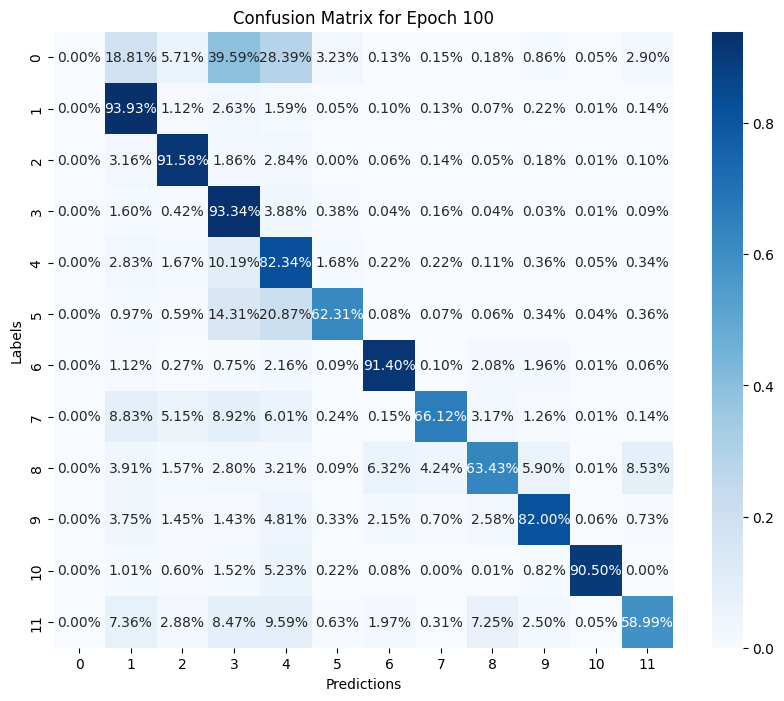

In [20]:


train()

writer.close()